# Insight 1

Tasa de aprobacion y perfil por producto y grupo ejecutivo

In [1]:
import pandas as pd
import os
import numpy as np

# --- 1. CONFIGURACIÓN DE LA RUTA ---
# Nota: Corregí el nombre quitando el "~$" que indica archivo temporal
ruta_carpeta = '/Users/diego/Documents/vsCode/proyecto_amex_kaggle/sql/'
nombre_archivo = 'Business Case_Business Analyst_REQ_25020234 copy.xlsx' 
full_path = os.path.join(ruta_carpeta, nombre_archivo)

print(f"Leyendo archivo desde: {full_path}...")

try:
    # --- 2. CARGA DE HOJAS ---
    # Cargamos todas las hojas en memoria
    xls = pd.ExcelFile(full_path)
    
    # Leemos cada hoja en un DataFrame separado
    df_app = pd.read_excel(xls, 'APLICACION')
    df_dec = pd.read_excel(xls, 'DECISION')
    df_exec = pd.read_excel(xls, 'EJECUTIVO')
    df_perf = pd.read_excel(xls, 'PERFIL')

    # Limpieza básica de nombres de columnas (quitar espacios extra)
    for df in [df_app, df_dec, df_exec, df_perf]:
        df.columns = df.columns.str.strip()

    # --- 3. CONSOLIDACIÓN (LOS JOINS) ---
    # Unimos todo en una tabla maestra (Master Table)
    # Left Join para no perder solicitudes que quizás no tengan perfil o decisión (aunque deberían)
    df_master = df_app.merge(df_exec, on='EXECUTIVE_ID', how='left')
    df_master = df_master.merge(df_dec, on='PROSPECT_ID', how='left')
    df_master = df_master.merge(df_perf, on='PROSPECT_ID', how='left')

    # Creamos bandera numérica de aprobación (1 = Sí, 0 = No)
    # Ajusta 'APPROVED' si en tu excel dice 'APROBADO'
    df_master['es_aprobado'] = np.where(df_master['DECISION'] == 'APPROVED', 1, 0)

    # --- 4. CÁLCULO DE LA TABLA MAESTRA (Grupo + Producto) ---
    
    # A) Métricas de Volumen y Tasa
    stats_base = df_master.groupby(['GROUP', 'PRODUCT_CODE']).agg(
        Total_Solicitudes=('PROSPECT_ID', 'count'),
        Total_Aceptadas=('es_aprobado', 'sum')
    ).reset_index()
    
    stats_base['Tasa_Aprobacion_Pct'] = (stats_base['Total_Aceptadas'] / stats_base['Total_Solicitudes']) * 100

    # B) Características (SOLO de las Aprobadas)
    # Filtramos primero para no promediar ingresos de gente rechazada
    df_aprobados = df_master[df_master['es_aprobado'] == 1]
    
    stats_perfil = df_aprobados.groupby(['GROUP', 'PRODUCT_CODE']).agg(
        Ingreso_Promedio_Aprobados=('INCOME', 'mean'),
        Score_Buro_Promedio=('CB_SCORE', 'mean'),
        Score_Interno_Promedio=('ADSS_SCORE', 'mean')
    ).reset_index()

    # C) Unimos A y B
    reporte_final = stats_base.merge(stats_perfil, on=['GROUP', 'PRODUCT_CODE'], how='left')

    # Limpieza final de decimales
    reporte_final = reporte_final.round(2)
    # Rellenar nulos en características (donde hubo 0 aprobados)
    reporte_final = reporte_final.fillna({
        'Ingreso_Promedio_Aprobados': 0,
        'Score_Buro_Promedio': 0,
        'Score_Interno_Promedio': 0
    })

    # --- 5. BENCHMARKS (Promedios Globales) ---
    benchmark_prod = df_master.groupby('PRODUCT_CODE')['es_aprobado'].mean() * 100
    benchmark_grupo = df_master.groupby('GROUP')['es_aprobado'].mean() * 100

    # --- 6. IMPRIMIR RESULTADOS ---
    print("\n" + "="*50)
    print("REPORTE ESTRATÉGICO GENERADO")
    print("="*50)
    
    print("\n--- TABLA DETALLADA (Muestra Top 10) ---")
    print(reporte_final.head(10))

    print("\n--- BENCHMARK: ACEPTACIÓN PROMEDIO POR PRODUCTO ---")
    print(benchmark_prod.round(2))

    print("\n--- BENCHMARK: ACEPTACIÓN PROMEDIO POR GRUPO ---")
    print(benchmark_grupo.round(2))

    # Opcional: Guardar a Excel
    output_path = os.path.join(ruta_carpeta, 'Reporte_Analisis_MBA.xlsx')
    reporte_final.to_excel(output_path, index=False)
    print(f"\nArchivo guardado exitosamente en: {output_path}")

except FileNotFoundError:
    print("\n❌ ERROR: No encuentro el archivo.")
    print(f"Buscando en: {full_path}")
    print("Por favor verifica que el nombre sea correcto y NO empiece con '~$'.")
except Exception as e:
    print(f"\n❌ Ocurrió un error inesperado: {e}")

Leyendo archivo desde: /Users/diego/Documents/vsCode/proyecto_amex_kaggle/sql/Business Case_Business Analyst_REQ_25020234 copy.xlsx...

REPORTE ESTRATÉGICO GENERADO

--- TABLA DETALLADA (Muestra Top 10) ---
      GROUP  PRODUCT_CODE  Total_Solicitudes  Total_Aceptadas  \
0  GRUPO 01            21                 26               17   
1  GRUPO 01            33                 10                4   
2  GRUPO 01            50                 35               23   
3  GRUPO 01            52                127               72   
4  GRUPO 01            65                 59               36   
5  GRUPO 01            80                 27               15   
6  GRUPO 02            15                  1                0   
7  GRUPO 02            21                 34               11   
8  GRUPO 02            33                 28               15   
9  GRUPO 02            50                 62               42   

   Tasa_Aprobacion_Pct  Ingreso_Promedio_Aprobados  Score_Buro_Promedio  \
0 

Cargando la evidencia...


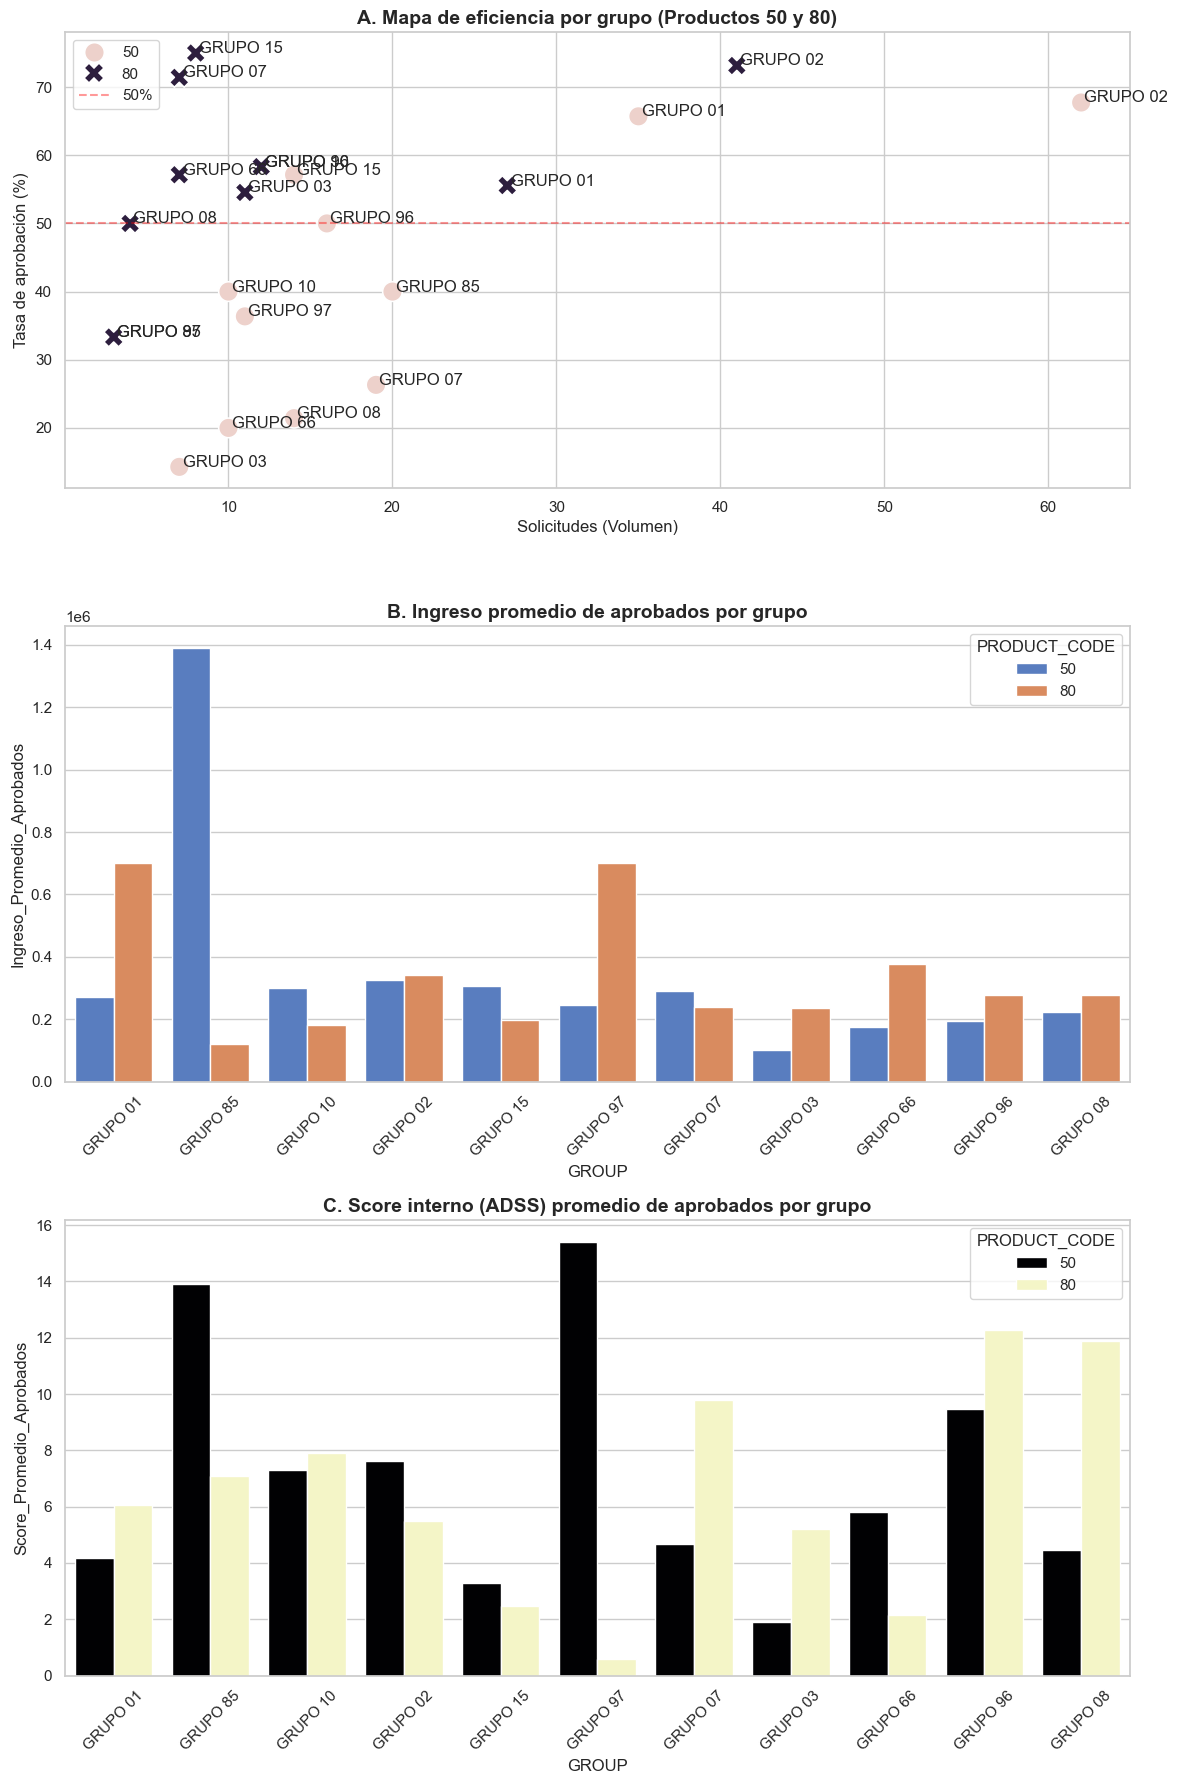

In [2]:
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
import numpy as np

# --- 1. CARGA DE DATOS ---
ruta_archivo = '/Users/diego/Documents/vsCode/proyecto_amex_kaggle/sql/Business Case_Business Analyst_REQ_25020234 copy.xlsx'

print("Cargando la evidencia...")
xls = pd.ExcelFile(ruta_archivo)
df = (
    pd.read_excel(xls, 'APLICACION')
    .merge(pd.read_excel(xls, 'EJECUTIVO'), on='EXECUTIVE_ID', how='left')
    .merge(pd.read_excel(xls, 'DECISION'),  on='PROSPECT_ID',  how='left')
    .merge(pd.read_excel(xls, 'PERFIL'),    on='PROSPECT_ID',  how='left')
)

# Bandera de Aprobación (1/0)
df['Aprobado'] = np.where(df['DECISION'] == 'APPROVED', 1, 0)

# FILTRO: Solo Productos 50 y 80 (foco del análisis)
df_focus = df[df['PRODUCT_CODE'].isin([50, 80])].copy()

# --- 2. PREPARACIÓN DE MÉTRICAS ---

# Métricas solo para combinaciones que SÍ tienen solicitudes
data_real = (
    df_focus
    .groupby(['PRODUCT_CODE', 'GROUP'])
    .agg(
        Volumen=('PROSPECT_ID', 'count'),
        Tasa_Aprobacion=('Aprobado', 'mean'),
        Ingreso_Promedio_Aprobados=(
            'INCOME',
            lambda x: x[df_focus.loc[x.index, 'Aprobado'] == 1].mean()
        ),
        Score_Promedio_Aprobados=(
            'ADSS_SCORE',
            lambda x: x[df_focus.loc[x.index, 'Aprobado'] == 1].mean()
        ),
    )
    .reset_index()
)

data_real['Tasa_Aprobacion_Pct'] = data_real['Tasa_Aprobacion'] * 100

# --- 2.1. COMPLETAR GRUPOS SIN SOLICITUDES (NO ESCONDER) ---

# Todos los grupos existentes en la organización
todos_grupos = (
    df[['GROUP']]
    .drop_duplicates()
    .rename(columns={'GROUP': 'GROUP'})
)

# Todos los productos de interés
productos = pd.DataFrame({'PRODUCT_CODE': [50, 80]})

# Matriz completa producto x grupo (incluye combinaciones sin datos)
grid = (
    productos.assign(key=1)
    .merge(todos_grupos.assign(key=1), on='key')
    .drop(columns='key')
)

# LEFT JOIN con métricas reales
data_agg = grid.merge(
    data_real,
    on=['PRODUCT_CODE', 'GROUP'],
    how='left'
)

# Rellenar Volumen y Tasa con 0 cuando no hubo solicitudes
data_agg['Volumen'] = data_agg['Volumen'].fillna(0).astype(int)
data_agg['Tasa_Aprobacion'] = data_agg['Tasa_Aprobacion'].fillna(0.0)
data_agg['Tasa_Aprobacion_Pct'] = data_agg['Tasa_Aprobacion'] * 100

# Ingreso/Score quedan como NaN si no hubo aprobados (tiene sentido: no hay perfil)

# --- 3. VISUALIZACIÓN EXPLORATORIA ---

sns.set_theme(style="whitegrid")
fig, axes = plt.subplots(3, 1, figsize=(12, 18))  # 3 Gráficos verticales

# GRÁFICO A: MAPA DE EFICIENCIA (Scatter Plot)
sns.scatterplot(
    data=data_agg,
    x='Volumen',
    y='Tasa_Aprobacion_Pct',
    hue='PRODUCT_CODE',
    style='PRODUCT_CODE',
    s=200,
    ax=axes[0]
)

# Etiquetas para TODOS los grupos
for i in range(data_agg.shape[0]):
    row = data_agg.iloc[i]
    axes[0].text(
        row['Volumen'] + 0.2,
        row['Tasa_Aprobacion_Pct'],
        f"{row['GROUP']}",
        fontsize=12
    )

axes[0].set_title(
    'A. Mapa de eficiencia por grupo (Productos 50 y 80)',
    fontsize=14,
    fontweight='bold'
)
axes[0].set_xlabel('Solicitudes (Volumen)')
axes[0].set_ylabel('Tasa de aprobación (%)')
axes[0].axhline(50, color='red', linestyle='--', alpha=0.4, label='50%')
axes[0].legend()

# GRÁFICO B: INGRESO PROMEDIO DE APROBADOS
sns.barplot(
    data=data_agg,
    x='GROUP',
    y='Ingreso_Promedio_Aprobados',
    hue='PRODUCT_CODE',
    palette='muted',
    ax=axes[1]
)
axes[1].set_title(
    'B. Ingreso promedio de aprobados por grupo',
    fontsize=14,
    fontweight='bold'
)
axes[1].tick_params(axis='x', rotation=45)

# GRÁFICO C: SCORE INTERNO PROMEDIO DE APROBADOS
sns.barplot(
    data=data_agg,
    x='GROUP',
    y='Score_Promedio_Aprobados',
    hue='PRODUCT_CODE',
    palette='magma',
    ax=axes[2]
)
axes[2].set_title(
    'C. Score interno (ADSS) promedio de aprobados por grupo',
    fontsize=14,
    fontweight='bold'
)
axes[2].tick_params(axis='x', rotation=45)

plt.tight_layout()
plt.show()


Auditando al Grupo 02 (incluyendo ejecutivos sin solicitudes 50/80)...

Archivo generado: 'Auditoria_Grupo02_Detalle_Todos_Ejecutivos.xlsx'


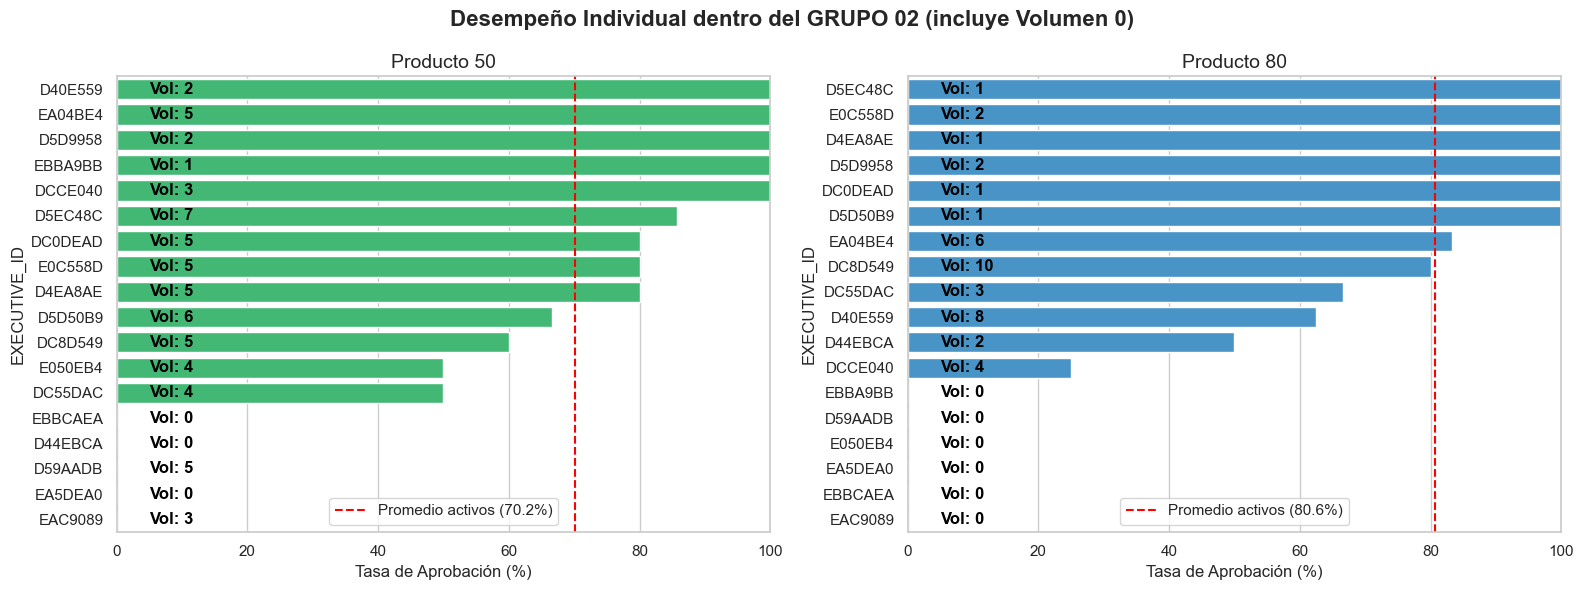

In [3]:
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
import numpy as np

ruta_archivo = '/Users/diego/Documents/vsCode/proyecto_amex_kaggle/sql/Business Case_Business Analyst_REQ_25020234 copy.xlsx'
print("Auditando al Grupo 02 (incluyendo ejecutivos sin solicitudes 50/80)...")

try:
    xls = pd.ExcelFile(ruta_archivo)

    # --- 1. CARGA POR SEPARADO ---
    df_aplicacion = pd.read_excel(xls, 'APLICACION')
    df_ejecutivo = pd.read_excel(xls, 'EJECUTIVO')
    df_decision = pd.read_excel(xls, 'DECISION')

    # --- 2. BASE: EJECUTIVO (para no perder a nadie) ---
    df = df_ejecutivo.merge(
        df_aplicacion,
        on='EXECUTIVE_ID',
        how='left'           # TODOS los ejecutivos, aunque no tengan solicitudes
    ).merge(
        df_decision,
        on='PROSPECT_ID',
        how='left'
    )

    df['Aprobado'] = np.where(df['DECISION'] == 'APPROVED', 1, 0)

    # Solo GRUPO 02
    df_g02 = df[df['GROUP'] == 'GRUPO 02'].copy()

    # --- 3. MÉTRICAS SOLO DONDE SÍ HAY SOLICITUDES 50/80 ---
    df_g02_prod = df_g02[df_g02['PRODUCT_CODE'].isin([50, 80])].copy()

    agg_metrics = df_g02_prod.groupby(['PRODUCT_CODE', 'EXECUTIVE_ID']).agg(
        Volumen=('PROSPECT_ID', 'count'),
        Tasa_Aprobacion=('Aprobado', 'mean')
    ).reset_index()

    # --- 4. TODAS LAS COMBINACIONES EJECUTIVO × PRODUCTO (50, 80) ---
    ejecutivos_g02 = df_g02[['EXECUTIVE_ID']].drop_duplicates()

    productos = pd.DataFrame({'PRODUCT_CODE': [50, 80]})

    ejecutivos_productos = (
        ejecutivos_g02.assign(key=1)
        .merge(productos.assign(key=1), on='key')
        .drop(columns='key')
    )

    # LEFT JOIN contra las métricas agregadas
    exec_metrics = ejecutivos_productos.merge(
        agg_metrics,
        on=['PRODUCT_CODE', 'EXECUTIVE_ID'],
        how='left'
    )

    # Ejecutivos sin solicitudes 50/80 → Volumen = 0, tasa = NaN (no definida)
    exec_metrics['Volumen'] = exec_metrics['Volumen'].fillna(0).astype(int)
    # NO rellenamos Tasa_Aprobacion con 0; NaN indica "sin datos"
    exec_metrics['Tasa_Aprobacion_Pct'] = exec_metrics['Tasa_Aprobacion'] * 100

    # --- 5. EXPORTACIÓN ---
    nombre_excel = 'Auditoria_Grupo02_Detalle_Todos_Ejecutivos.xlsx'
    exec_metrics.to_excel(nombre_excel, index=False)
    print(f"\nArchivo generado: '{nombre_excel}'")

    # --- 6. VISUALIZACIÓN ---
    sns.set_theme(style="whitegrid")
    fig, axes = plt.subplots(1, 2, figsize=(16, 6))
    fig.suptitle('Desempeño Individual dentro del GRUPO 02 (incluye Volumen 0)', fontsize=16, fontweight='bold')

    productos_lista = [50, 80]
    colores = ['#2ecc71', '#3498db']  # Verde y Azul

    for i, prod in enumerate(productos_lista):
        data_prod = (
            exec_metrics[exec_metrics['PRODUCT_CODE'] == prod]
            .copy()
        )

        # Columna solo para el gráfico: NaN -> 0
        data_prod['Tasa_Aprobacion_Pct_plot'] = data_prod['Tasa_Aprobacion_Pct'].fillna(0)

        # Ordenar por la tasa (para que los 0 queden normalmente abajo)
        data_prod = data_prod.sort_values('Tasa_Aprobacion_Pct_plot', ascending=False)

        if not data_prod.empty:
            # Promedio del grupo SOLO con ejecutivos que tienen volumen > 0
            data_activos = data_prod[data_prod['Volumen'] > 0]

            if not data_activos.empty:
                promedio_grupo = data_activos['Tasa_Aprobacion_Pct'].mean()
            else:
                promedio_grupo = np.nan  # por si para ese producto nadie tiene solicitudes

            sns.barplot(
                data=data_prod,
                x='Tasa_Aprobacion_Pct_plot',
                y='EXECUTIVE_ID',
                color=colores[i],
                ax=axes[i]
            )

            if not np.isnan(promedio_grupo):
                axes[i].axvline(
                    promedio_grupo,
                    color='red',
                    linestyle='--',
                    label=f'Promedio activos ({promedio_grupo:.1f}%)'
                )

            axes[i].set_title(f'Producto {prod}', fontsize=14)
            axes[i].set_xlabel('Tasa de Aprobación (%)')
            axes[i].set_xlim(0, 100)
            axes[i].legend()

            # Etiquetas con Volumen
            for idx, row in data_prod.iterrows():
                y_loc = list(data_prod['EXECUTIVE_ID']).index(row['EXECUTIVE_ID'])
                axes[i].text(
                    5,
                    y_loc,
                    f"Vol: {row['Volumen']}",
                    color='black',
                    va='center',
                    fontweight='bold'
                )

    plt.tight_layout()
    plt.show()

except FileNotFoundError:
    print("Error: No se encontró el archivo Excel en la ruta especificada.")
except Exception as e:
    print(f"Ocurrió un error: {e}")


In [4]:
import pandas as pd
import numpy as np

# --- 1. CONFIGURACIÓN ---
ruta_archivo = '/Users/diego/Documents/vsCode/proyecto_amex_kaggle/sql/Business Case_Business Analyst_REQ_25020234 copy.xlsx'
print("Iniciando cacería de registros tóxicos (Score < 400)...")

try:
    xls = pd.ExcelFile(ruta_archivo)
    # Cargamos tablas
    df = pd.read_excel(xls, 'APLICACION')\
        .merge(pd.read_excel(xls, 'EJECUTIVO'), on='EXECUTIVE_ID', how='left')\
        .merge(pd.read_excel(xls, 'PERFIL'), on='PROSPECT_ID', how='left')\
        .merge(pd.read_excel(xls, 'DECISION'), on='PROSPECT_ID', how='left')

    # --- 2. FILTRO DE "BASURA" ---
    # Buscamos Scores menores a 400 en los productos clave (50 y 80)
    # Estos suelen ser errores (-1, 0, etc.)
    df_toxic = df[
        (df['CB_SCORE'] < 400) & 
        (df['PRODUCT_CODE'].isin([50, 80]))
    ].copy()

    # --- 3. GENERACIÓN DEL REPORTE ---
    # Agrupamos para ver quiénes son los mayores ofensores
    reporte_toxicidad = df_toxic.groupby(['GROUP', 'EXECUTIVE_ID', 'PRODUCT_CODE']).agg(
        Solicitudes_Basura=('PROSPECT_ID', 'count'),
        Score_Minimo_Detectado=('CB_SCORE', 'min'),
        Score_Maximo_Detectado=('CB_SCORE', 'max'),
        # Vemos si alguna de estas basuras fue aprobada por error
        Aprobadas_Por_Error=('DECISION', lambda x: (x == 'APPROVED').sum())
    ).reset_index()

    # Ordenamos: Los peores arriba
    reporte_toxicidad = reporte_toxicidad.sort_values('Solicitudes_Basura', ascending=False)

    # --- 4. EXPORTACIÓN ---
    nombre_excel = 'Ejecutivos_Ventas_Toxicas.xlsx'
    reporte_toxicidad.to_excel(nombre_excel, index=False)
    
    print(f"\n¡Capturados! Se encontraron {len(df_toxic)} solicitudes con Score < 400.")
    print(f"El reporte detallado está en: {nombre_excel}")
    
    # --- 5. VISUALIZACIÓN RÁPIDA EN CONSOLA ---
    print("\nTOP 10 EJECUTIVOS CON VENTAS DE BAJA CALIDAD (SCORE < 400):")
    print(reporte_toxicidad.head(10).to_string())

except FileNotFoundError:
    print("❌ Error: Verifica la ruta del archivo.")
except Exception as e:
    print(f"❌ Error: {e}")

Iniciando cacería de registros tóxicos (Score < 400)...

¡Capturados! Se encontraron 19 solicitudes con Score < 400.
El reporte detallado está en: Ejecutivos_Ventas_Toxicas.xlsx

TOP 10 EJECUTIVOS CON VENTAS DE BAJA CALIDAD (SCORE < 400):
       GROUP EXECUTIVE_ID  PRODUCT_CODE  Solicitudes_Basura  Score_Minimo_Detectado  Score_Maximo_Detectado  Aprobadas_Por_Error
11  GRUPO 10      DCD4DBA            80                   3                    -8.0                     9.0                    1
13  GRUPO 96      DA5DCDD            80                   2                    -9.0                     9.0                    1
0   GRUPO 01      D4CE45C            80                   1                     0.0                     0.0                    0
1   GRUPO 01      EADE8B5            80                   1                     0.0                     0.0                    0
2   GRUPO 02      DC0DEAD            50                   1                    -9.0                    -9.0         

Generando Perfil Limpio (Sin Scores < 400)...
Base Limpia: 183 clientes aprobados y validados.
Tabla guardada en: Perfil_Limpio_Prod50_80.xlsx


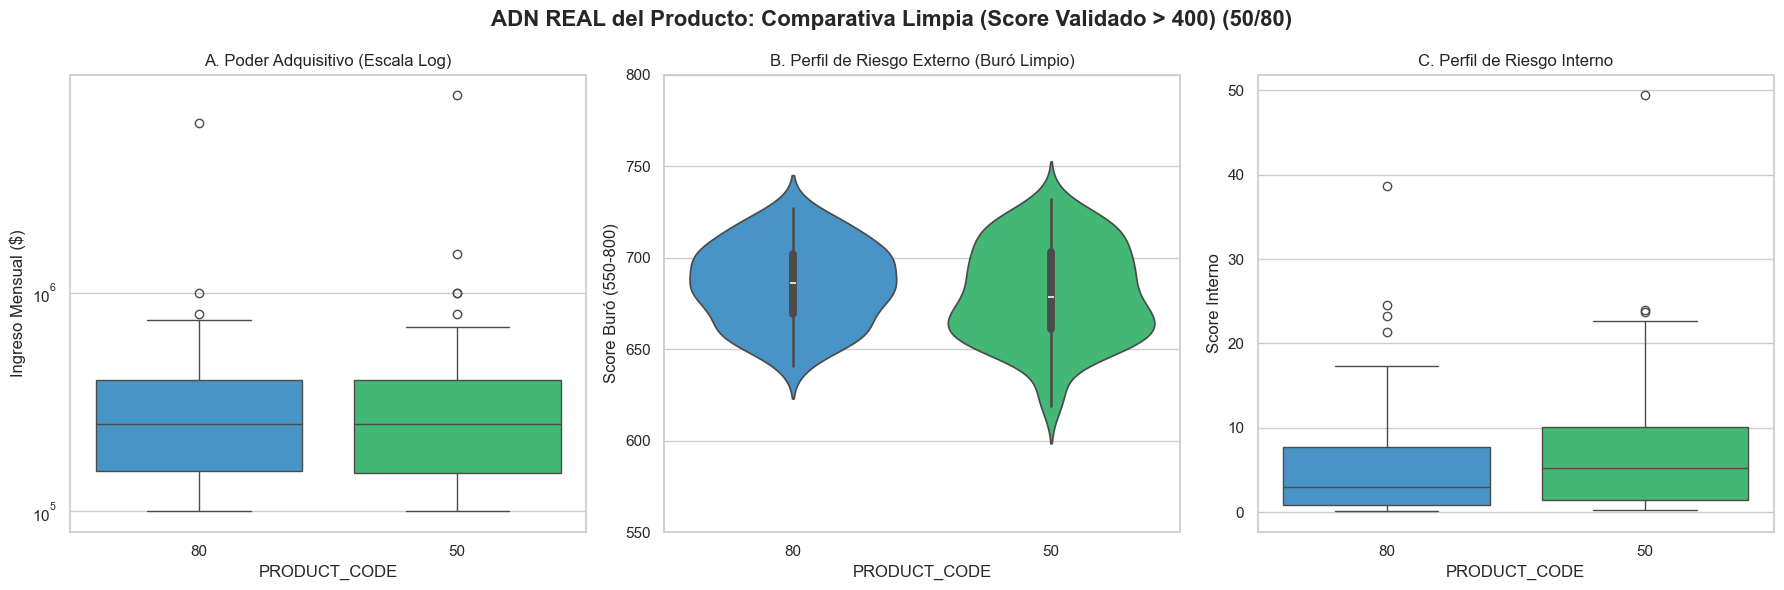


--- RESUMEN DE PERFIL LIMPIO ---
  PRODUCT_CODE  Total_Clientes  Ingreso_Mediana  Ingreso_Promedio  Score_Buro_Promedio  Score_Buro_Minimo  Score_Buro_Maximo  Score_Interno_Promedio
0           50             104         250000.0         374971.15               680.54              619.0              732.0                    7.02
1           80              79         250000.0         369003.85               685.56              641.0              727.0                    5.63


In [5]:
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
import numpy as np

# --- 1. CONFIGURACIÓN ---
ruta_archivo = '/Users/diego/Documents/vsCode/proyecto_amex_kaggle/sql/Business Case_Business Analyst_REQ_25020234 copy.xlsx'
print("Generando Perfil Limpio (Sin Scores < 400)...")

try:
    xls = pd.ExcelFile(ruta_archivo)
    df = pd.read_excel(xls, 'APLICACION')\
        .merge(pd.read_excel(xls, 'DECISION'), on='PROSPECT_ID', how='inner')\
        .merge(pd.read_excel(xls, 'PERFIL'), on='PROSPECT_ID', how='inner')

    # Forzar Producto a Texto para evitar errores de graficación
    df['PRODUCT_CODE'] = df['PRODUCT_CODE'].astype(str)

    # --- 2. EL FILTRO DE SANIDAD ---
    # Nos quedamos SOLO con:
    # a) Productos 50 y 80
    # b) Aprobados
    # c) Score >= 400 (Adiós a los códigos de error -1, 0, etc.)
    df_clean = df[
        (df['PRODUCT_CODE'].isin(['50', '80'])) & 
        (df['DECISION'] == 'APPROVED') &
        (df['CB_SCORE'] >= 400) 
    ].copy()

    print(f"Base Limpia: {len(df_clean)} clientes aprobados y validados.")

    # --- 3. GENERACIÓN DE ESTADÍSTICAS LIMPIAS ---
    perfil_clean = df_clean.groupby('PRODUCT_CODE').agg(
        Total_Clientes=('PROSPECT_ID', 'count'),
        Ingreso_Mediana=('INCOME', 'median'),
        Ingreso_Promedio=('INCOME', 'mean'),
        Score_Buro_Promedio=('CB_SCORE', 'mean'),
        Score_Buro_Minimo=('CB_SCORE', 'min'), # Debería ser >= 400
        Score_Buro_Maximo=('CB_SCORE', 'max'),
        Score_Interno_Promedio=('ADSS_SCORE', 'mean')
    ).reset_index().round(2)

    # Exportar Excel
    nombre_excel = 'Perfil_Limpio_Prod50_80.xlsx'
    perfil_clean.to_excel(nombre_excel, index=False)
    print(f"Tabla guardada en: {nombre_excel}")

    # --- 4. VISUALIZACIÓN COMPARATIVA (AHORA SÍ REALISTA) ---
    sns.set_theme(style="whitegrid")
    fig, axes = plt.subplots(1, 3, figsize=(18, 6))
    fig.suptitle('ADN REAL del Producto: Comparativa Limpia (Score Validado > 400) (50/80)', fontsize=16, fontweight='bold')

    palette_prod = {'50': '#2ecc71', '80': '#3498db'} # Verde y Azul

    # A. PODER ADQUISITIVO (Sin cambios, pero con base limpia)
    sns.boxplot(
        data=df_clean, x='PRODUCT_CODE', y='INCOME', 
        hue='PRODUCT_CODE', palette=palette_prod, legend=False, ax=axes[0]
    )
    axes[0].set_yscale('log') 
    axes[0].set_title('A. Poder Adquisitivo (Escala Log)', fontsize=12)
    axes[0].set_ylabel('Ingreso Mensual ($)')

    # B. SCORE DE BURÓ (El cambio drástico estará aquí)
    sns.violinplot(
        data=df_clean, x='PRODUCT_CODE', y='CB_SCORE', 
        hue='PRODUCT_CODE', palette=palette_prod, legend=False, ax=axes[1]
    )
    # Ajustamos el eje Y para ver detalle entre 400 y 850
    axes[1].set_ylim(550, 800) 
    axes[1].set_title('B. Perfil de Riesgo Externo (Buró Limpio)', fontsize=12)
    axes[1].set_ylabel('Score Buró (550-800)')
    
    # C. SCORE INTERNO
    sns.boxplot(
        data=df_clean, x='PRODUCT_CODE', y='ADSS_SCORE', 
        hue='PRODUCT_CODE', palette=palette_prod, legend=False, ax=axes[2]
    )
    axes[2].set_title('C. Perfil de Riesgo Interno', fontsize=12)
    axes[2].set_ylabel('Score Interno')

    plt.tight_layout()
    plt.show()

    print("\n--- RESUMEN DE PERFIL LIMPIO ---")
    print(perfil_clean.to_string())

except FileNotFoundError:
    print("❌ Error: No encuentro el archivo Excel.")
except Exception as e:
    print(f"❌ Error: {e}")

In [6]:
# total solicitudes 50 en la base completa (df)
total_50 = len(df[df['PRODUCT_CODE'].astype(str) == '50'])

# total solicitudes 50 aprobadas
total_50_apr = df[
    (df['PRODUCT_CODE'].astype(str) == '50') &
    (df['DECISION'] == 'APPROVED')
].shape[0]

# total solicitudes 50 aprobadas y con CB_SCORE >= 400
total_50_clean = df_clean[df_clean['PRODUCT_CODE'] == '50'].shape[0]

print("Total 50 en df          :", total_50)
print("Total 50 aprobadas      :", total_50_apr)
print("Total 50 apr CB>=400    :", total_50_clean)


Total 50 en df          : 218
Total 50 aprobadas      : 108
Total 50 apr CB>=400    : 104


In [7]:
import pandas as pd
import numpy as np

# Carga de datos (Ajusta tu ruta si es necesario)
ruta_archivo = '/Users/diego/Documents/vsCode/proyecto_amex_kaggle/sql/Business Case_Business Analyst_REQ_25020234 copy.xlsx'
xls = pd.ExcelFile(ruta_archivo)

# Cargar y unir
df = pd.read_excel(xls, 'APLICACION')\
    .merge(pd.read_excel(xls, 'EJECUTIVO'), on='EXECUTIVE_ID', how='left')\
    .merge(pd.read_excel(xls, 'PERFIL'), on='PROSPECT_ID', how='left')\
    .merge(pd.read_excel(xls, 'DECISION'), on='PROSPECT_ID', how='left')

# Crear bandera de Grupo 02 vs Resto
df['Segmento_Grupo'] = np.where(df['GROUP'] == 'GRUPO 02', 'GRUPO 02 (Estrella)', 'RESTO DE GRUPOS')

# Filtramos solo Productos 50 y 80 (El foco de la VP)
df_focus = df[df['PRODUCT_CODE'].isin([50, 80])].copy()

# --- ANÁLISIS 1: CALIDAD DEL PROSPECTO (INPUT) ---
# ¿Qué tan buenos son los clientes que TRAEN (no solo los que aprueban)?
calidad_input = df_focus.groupby(['Segmento_Grupo', 'PRODUCT_CODE']).agg(
    Volumen_Solicitudes=('PROSPECT_ID', 'count'),
    Ingreso_Promedio_Solicitante=('INCOME', 'median'), # Mediana para evitar sesgos
    Score_Buro_Promedio_Solicitante=('CB_SCORE', 'mean'),
    Score_Interno_Promedio=('ADSS_SCORE', 'mean'),
    Tasa_Aprobacion_Real=('DECISION', lambda x: (x == 'APPROVED').mean() * 100)
).reset_index().round(2)

# Mediana de ingreso por segmento y producto
mediana_ingreso = (
    df_focus.groupby(['Segmento_Grupo', 'PRODUCT_CODE'])['INCOME']
    .median()
    .reset_index(name='Ingreso_Mediana_Solicitante')
).round(2)


# --- ANÁLISIS 2: EL FACTOR UBICACIÓN (POINT OF SALE) ---
# ¿Dónde está vendiendo el Grupo 02?
pos_analysis = df_focus[df_focus['GROUP'] == 'GRUPO 02']['POINT_OF_SALES_ID'].value_counts().head(5)

print("--- 1. COMPARATIVA DE 'MATERIA PRIMA' (CLIENTES INGRESADOS) ---")
print(calidad_input.to_string())
print("\n--- 1.B MEDIANA DE INGRESO POR SEGMENTO Y PRODUCTO ---")
print(mediana_ingreso.to_string(index=False))


print("\n--- 2. TOP 5 PUNTOS DE VENTA DEL GRUPO 02 ---")
print(pos_analysis)

--- 1. COMPARATIVA DE 'MATERIA PRIMA' (CLIENTES INGRESADOS) ---
        Segmento_Grupo  PRODUCT_CODE  Volumen_Solicitudes  Ingreso_Promedio_Solicitante  Score_Buro_Promedio_Solicitante  Score_Interno_Promedio  Tasa_Aprobacion_Real
0  GRUPO 02 (Estrella)            50                   62                      300000.0                           657.25                   11.90                 67.74
1  GRUPO 02 (Estrella)            80                   41                      400000.0                           688.97                    6.65                 73.17
2      RESTO DE GRUPOS            50                  156                      200000.0                           633.97                   22.94                 42.31
3      RESTO DE GRUPOS            80                   94                      200000.0                           590.88                   10.38                 57.45

--- 1.B MEDIANA DE INGRESO POR SEGMENTO Y PRODUCTO ---
     Segmento_Grupo  PRODUCT_CODE  Ingreso_Me

Analizando hipótesis de F053 como ubicación prime...

Top puntos de venta de GRUPO 02 (share dentro del grupo):
  POINT_OF_SALES_ID  ventas_g2  share_g2_en_pos
1              F053         31         0.430556
4              F120         16         0.222222
3              F074          8         0.111111
7              F126          7         0.097222
0              F048          4         0.055556
6              F125          3         0.041667
2              F071          2         0.027778
5              F123          1         0.013889

Share de F053 dentro de las ventas aprobadas de GRUPO 02: 43.1%

Matriz de correlaciones (a nivel punto de venta):
share_g2_aprobadas     1.000000
tasa_aprobacion        0.338500
cb_score_promedio      0.252092
adss_score_promedio   -0.055717
ingreso_promedio      -0.149874
Name: share_g2_aprobadas, dtype: float64

Métricas de F053:
   POINT_OF_SALES_ID  ventas_total  ingreso_promedio  cb_score_promedio  \
11              F053            37     289810

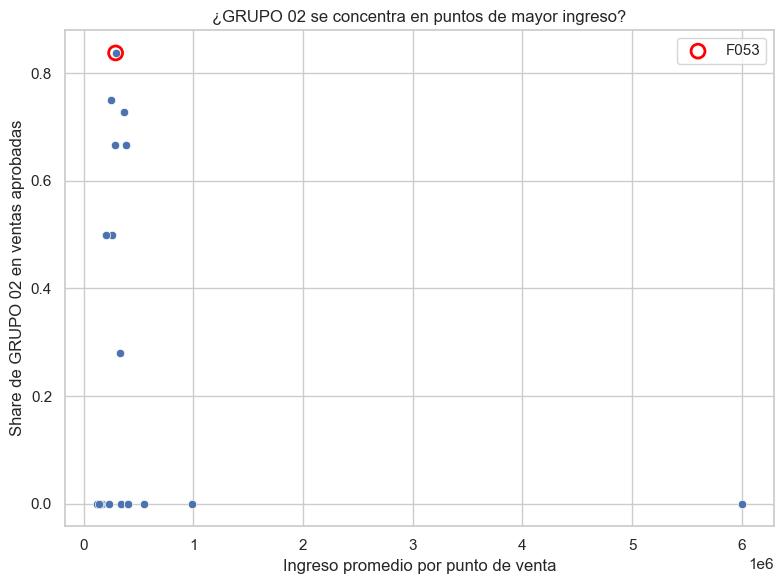

In [8]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns

ruta_archivo = '/Users/diego/Documents/vsCode/proyecto_amex_kaggle/sql/Business Case_Business Analyst_REQ_25020234 copy.xlsx'
print("Analizando hipótesis de F053 como ubicación prime...")

xls = pd.ExcelFile(ruta_archivo)

# 1. Carga y merge base
df_aplicacion = pd.read_excel(xls, 'APLICACION')
df_decision = pd.read_excel(xls, 'DECISION')
df_ejecutivo = pd.read_excel(xls, 'EJECUTIVO')
df_perfil = pd.read_excel(xls, 'PERFIL')

df = (
    df_aplicacion
    .merge(df_decision, on='PROSPECT_ID', how='inner')
    .merge(df_ejecutivo, on='EXECUTIVE_ID', how='inner')
    .merge(df_perfil, on='PROSPECT_ID', how='inner')
)

# Opcional: si "ventas" = productos 50 y 80
df = df[df['PRODUCT_CODE'].isin([50, 80])]

# Solo aprobadas si estás hablando de ventas, no solicitudes
df['es_aprobada'] = (df['DECISION'] == 'APPROVED').astype(int)

# ==========================
# 1) Confirmar concentración de Grupo 02 en F053
# ==========================

df_g2_aprob = df[(df['GROUP'] == 'GRUPO 02') & (df['DECISION'] == 'APPROVED')].copy()

ventas_g2_por_pos = (
    df_g2_aprob
    .groupby('POINT_OF_SALES_ID', as_index=False)
    .agg(ventas_g2=('PROSPECT_ID', 'count'))
)

ventas_g2_por_pos['share_g2_en_pos'] = (
    ventas_g2_por_pos['ventas_g2'] /
    ventas_g2_por_pos['ventas_g2'].sum()
)

ventas_g2_por_pos = ventas_g2_por_pos.sort_values('share_g2_en_pos', ascending=False)

print("\nTop puntos de venta de GRUPO 02 (share dentro del grupo):")
print(ventas_g2_por_pos.head(10))

share_f053 = ventas_g2_por_pos.loc[
    ventas_g2_por_pos['POINT_OF_SALES_ID'] == 'F053', 'share_g2_en_pos'
]

if not share_f053.empty:
    print(f"\nShare de F053 dentro de las ventas aprobadas de GRUPO 02: {share_f053.iloc[0]*100:.1f}%")
else:
    print("\nF053 no aparece en las ventas aprobadas de GRUPO 02 (revisa filtros).")

# ==========================
# 2) Métricas por punto de venta (proxy de 'prime')
# ==========================

df_aprob = df[df['DECISION'] == 'APPROVED'].copy()

pos_metrics = (
    df_aprob
    .groupby('POINT_OF_SALES_ID', as_index=False)
    .agg(
        ventas_total=('PROSPECT_ID', 'count'),
        ingreso_promedio=('INCOME', 'mean'),
        cb_score_promedio=('CB_SCORE', 'mean'),
        adss_score_promedio=('ADSS_SCORE', 'mean')
    )
)

# Tasa aprobación por punto de venta (necesitas también las solicitudes totales)
solicitudes_por_pos = (
    df
    .groupby('POINT_OF_SALES_ID', as_index=False)
    .agg(
        solicitudes_total=('PROSPECT_ID', 'count'),
        aprobadas=('es_aprobada', 'sum')
    )
)
solicitudes_por_pos['tasa_aprobacion'] = (
    solicitudes_por_pos['aprobadas'] / solicitudes_por_pos['solicitudes_total']
)

pos_metrics = pos_metrics.merge(
    solicitudes_por_pos[['POINT_OF_SALES_ID', 'solicitudes_total', 'tasa_aprobacion']],
    on='POINT_OF_SALES_ID',
    how='left'
)

# ==========================
# 3) Peso de GRUPO 02 en cada punto de venta
# ==========================

aprob_por_pos_y_grupo = (
    df_aprob
    .groupby(['POINT_OF_SALES_ID', 'GROUP'], as_index=False)
    .agg(ventas=('PROSPECT_ID', 'count'))
)

# Ventas totales aprobadas por POS
total_por_pos = (
    aprob_por_pos_y_grupo
    .groupby('POINT_OF_SALES_ID', as_index=False)
    .agg(ventas_total_pos=('ventas', 'sum'))
)

# Ventas aprobadas de GRUPO 02 por POS
g2_por_pos = (
    aprob_por_pos_y_grupo[aprob_por_pos_y_grupo['GROUP'] == 'GRUPO 02']
    .rename(columns={'ventas': 'ventas_g2_pos'})
    [['POINT_OF_SALES_ID', 'ventas_g2_pos']]
)

pos_share_g2 = (
    total_por_pos
    .merge(g2_por_pos, on='POINT_OF_SALES_ID', how='left')
)

pos_share_g2['ventas_g2_pos'] = pos_share_g2['ventas_g2_pos'].fillna(0)
pos_share_g2['share_g2_aprobadas'] = (
    pos_share_g2['ventas_g2_pos'] / pos_share_g2['ventas_total_pos']
)

# Merge con las métricas del punto
pos_metrics = pos_metrics.merge(
    pos_share_g2[['POINT_OF_SALES_ID', 'share_g2_aprobadas']],
    on='POINT_OF_SALES_ID',
    how='left'
)

# ==========================
# 4) Correlaciones
# ==========================

vars_correlacion = [
    'share_g2_aprobadas',
    'ingreso_promedio',
    'cb_score_promedio',
    'adss_score_promedio',
    'tasa_aprobacion'
]

corr = pos_metrics[vars_correlacion].corr()
print("\nMatriz de correlaciones (a nivel punto de venta):")
print(corr['share_g2_aprobadas'].sort_values(ascending=False))

# ==========================
# 5) Ver dónde cae F053 frente al resto
# ==========================

pos_f053 = pos_metrics[pos_metrics['POINT_OF_SALES_ID'] == 'F053']
print("\nMétricas de F053:")
print(pos_f053)

# Scatter: share Grupo 02 vs ingreso promedio
sns.set_theme(style="whitegrid")
plt.figure(figsize=(8, 6))
sns.scatterplot(
    data=pos_metrics,
    x='ingreso_promedio',
    y='share_g2_aprobadas'
)

if not pos_f053.empty:
    plt.scatter(
        pos_f053['ingreso_promedio'],
        pos_f053['share_g2_aprobadas'],
        s=100,
        edgecolor='red',
        facecolor='none',
        linewidth=2,
        label='F053'
    )

plt.xlabel('Ingreso promedio por punto de venta')
plt.ylabel('Share de GRUPO 02 en ventas aprobadas')
plt.title('¿GRUPO 02 se concentra en puntos de mayor ingreso?')
plt.legend()
plt.tight_layout()
plt.show()


--- DISTRIBUCION DE VOLUMEN DE SOLICITUDES (GRUPO 02) POR EJECUTIVO Y PRODUCTO ---
EXECUTIVE_ID PRODUCT_CODE  Volumen_Solicitudes
     DC8D549           80                   10
     D40E559           80                    8
     D5EC48C           50                    7
     D5D50B9           50                    6
     EA04BE4           80                    6
     EA04BE4           50                    5
     DC8D549           50                    5
     DC0DEAD           50                    5
     E0C558D           50                    5
     D59AADB           50                    5
     D4EA8AE           50                    5
     DC55DAC           50                    4
     DCCE040           80                    4
     E050EB4           50                    4
     EAC9089           50                    3
     DC55DAC           80                    3
     DCCE040           50                    3
     D5D9958           80                    2
     D5D9958           5

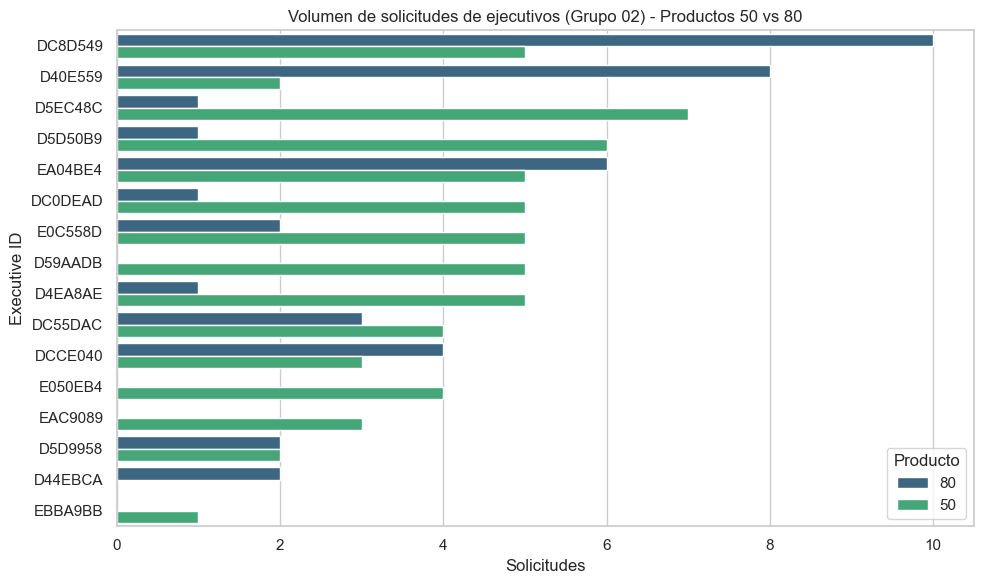

In [9]:
import pandas as pd
import seaborn as sns
import numpy as np
import matplotlib.pyplot as plt

# --- 1. CARGA DE DATOS ---
# El código verifica si 'df_focus' ya existe en tu memoria para no recargar el Excel si no es necesario.
if 'df_focus' not in globals():
    ruta_archivo = '/Users/diego/Documents/vsCode/proyecto_amex_kaggle/sql/Business Case_Business Analyst_REQ_25020234 copy.xlsx'
    print("Cargando datos desde archivo...")
    
    try:
        xls = pd.ExcelFile(ruta_archivo)
        df = pd.read_excel(xls, 'APLICACION')\
            .merge(pd.read_excel(xls, 'EJECUTIVO'), on='EXECUTIVE_ID', how='left')\
            .merge(pd.read_excel(xls, 'PERFIL'), on='PROSPECT_ID', how='left')\
            .merge(pd.read_excel(xls, 'DECISION'), on='PROSPECT_ID', how='left')
            
        # Crear etiquetas de segmento
        df['Segmento_Grupo'] = np.where(df['GROUP'] == 'GRUPO 02', 'GRUPO 02 (Estrella)', 'RESTO DE GRUPOS')
        
        # Filtro principal
        df_focus = df[df['PRODUCT_CODE'].isin([50, 80])].copy()
        print("Datos cargados correctamente.")
        
    except FileNotFoundError:
        print(f"❌ Error: No se encontró el archivo en: {ruta_archivo}")

# --- 2. PROCESAMIENTO ---
# Distribucion de volumen de solicitudes de ejecutivos del Grupo 02 por producto
volumen_exec = (
    df_focus[df_focus['GROUP'] == 'GRUPO 02']
    .groupby(['EXECUTIVE_ID', 'PRODUCT_CODE'])
    .agg(Volumen_Solicitudes=('PROSPECT_ID', 'count'))
    .reset_index()
    .sort_values('Volumen_Solicitudes', ascending=False)
)

# Convertimos a string para que el gráfico entienda que son categorías (Producto "50" y "80")
volumen_exec['PRODUCT_CODE'] = volumen_exec['PRODUCT_CODE'].astype(str)

print('--- DISTRIBUCION DE VOLUMEN DE SOLICITUDES (GRUPO 02) POR EJECUTIVO Y PRODUCTO ---')
print(volumen_exec.to_string(index=False))

# --- 3. VISUALIZACIÓN ---
plt.figure(figsize=(10, 6))
sns.barplot(
    data=volumen_exec,
    x='Volumen_Solicitudes',
    y='EXECUTIVE_ID',
    hue='PRODUCT_CODE',
    palette='viridis'
)

plt.title('Volumen de solicitudes de ejecutivos (Grupo 02) - Productos 50 vs 80')
plt.xlabel('Solicitudes')
plt.ylabel('Executive ID')
plt.legend(title='Producto')
plt.tight_layout()
plt.show()

In [10]:
import pandas as pd
import numpy as np

ruta_archivo = '/Users/diego/Documents/vsCode/proyecto_amex_kaggle/sql/Business Case_Business Analyst_REQ_25020234 copy.xlsx'

xls = pd.ExcelFile(ruta_archivo)

# --- 1. CARGA DE TABLAS BASE ---
df_aplicacion = pd.read_excel(xls, 'APLICACION')
df_decision   = pd.read_excel(xls, 'DECISION')
df_ejecutivo  = pd.read_excel(xls, 'EJECUTIVO')
df_perfil     = pd.read_excel(xls, 'PERFIL')

print("Solicitudes totales en APLICACION:", len(df_aplicacion))

# --- 2. NORMALIZAR PRODUCT_CODE Y QUEDARNOS SOLO CON 50 / 80 ---
df_aplicacion['PRODUCT_CODE_STR'] = (
    df_aplicacion['PRODUCT_CODE']
      .astype(str)
      .str.strip()
)

# extrae los dígitos (ej. '80X' -> '80')
df_aplicacion['PRODUCT_CODE_CLEAN'] = (
    df_aplicacion['PRODUCT_CODE_STR']
      .str.extract(r'(\d+)', expand=False)
      .astype('Int64')
)

df_aplicacion_5080 = df_aplicacion[
    df_aplicacion['PRODUCT_CODE_CLEAN'].isin([50, 80])
].copy()

print("Solicitudes 50/80 en APLICACION:", len(df_aplicacion_5080))

# --- 3. ARMAR BASE DETALLADA PARA 50/80 (SIN PERDER SOLICITUDES) ---
df_5080 = (
    df_aplicacion_5080
    .merge(df_decision,  on='PROSPECT_ID',  how='left')     # LEFT, no INNER
    .merge(df_ejecutivo, on='EXECUTIVE_ID', how='left')
    .merge(df_perfil,    on='PROSPECT_ID',  how='left')     # LEFT, no INNER
)

print("Solicitudes 50/80 tras merges:", len(df_5080))

df_5080['es_aprobada'] = (df_5080['DECISION'] == 'APPROVED').astype(int)

# --- 4. AGREGAR (SOLO COMBINACIONES QUE EXISTEN) ---
agg_exec_prod = (
    df_5080
    .groupby(['EXECUTIVE_ID', 'GROUP', 'PRODUCT_CODE_CLEAN'], as_index=False)
    .agg(
        solicitudes_total   = ('PROSPECT_ID', 'count'),
        aprobadas_total     = ('es_aprobada', 'sum'),
        ingreso_promedio    = ('INCOME', 'mean'),
        cb_score_promedio   = ('CB_SCORE', 'mean'),
        adss_score_promedio = ('ADSS_SCORE', 'mean')
    )
)

print("Suma de solicitudes_total en agg_exec_prod:",
      agg_exec_prod['solicitudes_total'].sum())

# --- 5. CREAR TODAS LAS COMBINACIONES EJECUTIVO × PRODUCTO (50, 80) ---
ejecutivos = df_ejecutivo[['EXECUTIVE_ID', 'GROUP']].drop_duplicates()
productos  = pd.DataFrame({'PRODUCT_CODE_CLEAN': [50, 80]})

exec_prod_grid = (
    ejecutivos.assign(key=1)
    .merge(productos.assign(key=1), on='key')
    .drop(columns='key')
)

# --- 6. LEFT JOIN PARA INCLUIR TAMBIÉN VOLÚMENES 0 ---
panel_exec_prod = exec_prod_grid.merge(
    agg_exec_prod,
    on=['EXECUTIVE_ID', 'GROUP', 'PRODUCT_CODE_CLEAN'],
    how='left'
)

panel_exec_prod['solicitudes_total'] = (
    panel_exec_prod['solicitudes_total']
    .fillna(0)
    .astype(int)
)
panel_exec_prod['aprobadas_total'] = (
    panel_exec_prod['aprobadas_total']
    .fillna(0)
    .astype(int)
)

panel_exec_prod['tasa_aprobacion'] = np.where(
    panel_exec_prod['solicitudes_total'] > 0,
    panel_exec_prod['aprobadas_total'] / panel_exec_prod['solicitudes_total'],
    np.nan
)

panel_exec_prod = panel_exec_prod.rename(
    columns={'PRODUCT_CODE_CLEAN': 'PRODUCT_CODE'}
)

print("Suma de solicitudes_total en panel_exec_prod:",
      panel_exec_prod['solicitudes_total'].sum())

print(panel_exec_prod)

# --- 7. EXPORTAR A EXCEL ---
nombre_salida = 'panel_exec_prod_50_80_por_ejecutivo.xlsx'
panel_exec_prod.to_excel(nombre_salida, index=False)
print(f"Archivo generado: {nombre_salida}")

Solicitudes totales en APLICACION: 1740
Solicitudes 50/80 en APLICACION: 353
Solicitudes 50/80 tras merges: 353
Suma de solicitudes_total en agg_exec_prod: 353
Suma de solicitudes_total en panel_exec_prod: 353
    EXECUTIVE_ID     GROUP  PRODUCT_CODE  solicitudes_total  aprobadas_total  \
0        D580CEC  GRUPO 01            50                  3                2   
1        D580CEC  GRUPO 01            80                  3                1   
2        D09E090  GRUPO 01            50                  1                0   
3        D09E090  GRUPO 01            80                  2                1   
4        D44B4C4  GRUPO 85            50                  0                0   
..           ...       ...           ...                ...              ...   
217      D59AAE8  GRUPO 01            80                  0                0   
218      EA84804  GRUPO 96            50                  2                2   
219      EA84804  GRUPO 96            80                  1           

In [11]:
import pandas as pd
import numpy as np

# 1. Cargar la matriz base (ejecutivo x producto)
panel_exec_prod = pd.read_excel('panel_exec_prod_50_80_por_ejecutivo.xlsx')

# Asegurar que tasa_aprobacion sea numérica
panel_exec_prod['tasa_aprobacion'] = pd.to_numeric(
    panel_exec_prod['tasa_aprobacion'],
    errors='coerce'
)

# 2. Calcular el promedio de solicitudes por producto (50 y 80)
promedio_volumen = (
    panel_exec_prod
    .groupby('PRODUCT_CODE', as_index=False)['solicitudes_total']
    .mean()
    .rename(columns={'solicitudes_total': 'promedio_solicitudes_producto'})
)

# 3. Anexar el promedio a cada fila (ejecutivo x producto)
panel_exec_prod = panel_exec_prod.merge(
    promedio_volumen,
    on='PRODUCT_CODE',
    how='left'
)

# 4. Definir segmentos:
#    - inactivo:              solicitudes_total == 0
#    - referente (ayuda):     solicitudes_total >= promedio_solicitudes_producto y solicitudes_total > 0
#    - activo_mejorar:        resto de los que tienen solicitudes > 0
def clasificar_segmento(row):
    if row['solicitudes_total'] == 0:
        return 'inactivo'
    if row['solicitudes_total'] >= row['promedio_solicitudes_producto']:
        return 'referente'
    return 'activo_mejorar'

panel_exec_prod['segmento'] = panel_exec_prod.apply(clasificar_segmento, axis=1)

# 5. Ejecutivos referentes por producto
referentes = (
    panel_exec_prod[panel_exec_prod['segmento'] == 'referente']
    .sort_values(['PRODUCT_CODE', 'tasa_aprobacion'], ascending=[True, False])
    [['PRODUCT_CODE', 'EXECUTIVE_ID', 'GROUP',
      'solicitudes_total', 'aprobadas_total', 'tasa_aprobacion']]
)

# 6. Ejecutivos inactivos por producto
inactivos = (
    panel_exec_prod[panel_exec_prod['segmento'] == 'inactivo']
    [['PRODUCT_CODE', 'EXECUTIVE_ID', 'GROUP', 'solicitudes_total']]
)

# 7. TOP 10 ejecutivos por producto
#    1) Orden por PRODUCT_CODE
#    2) Dentro de cada producto: solicitudes_total DESC
#    3) A empate de volumen: tasa_aprobacion DESC
top10 = (
    panel_exec_prod
    .sort_values(
        ['PRODUCT_CODE', 'solicitudes_total', 'tasa_aprobacion'],
        ascending=[True, False, False]
    )
    .groupby('PRODUCT_CODE', sort=False)
    .head(10)
    [['PRODUCT_CODE', 'EXECUTIVE_ID', 'GROUP', 'segmento',
      'solicitudes_total', 'aprobadas_total', 'tasa_aprobacion']]
)

print("\nTop 10 ejecutivos por producto (por volumen y luego tasa de aprobación):")
print(top10)

# 8. Renombrar columnas para archivos de salida (nombres cortos pero claros)
rename_map = {
    'EXECUTIVE_ID': 'ejecutivo',
    'GROUP': 'grupo',
    'PRODUCT_CODE': 'producto',
    'solicitudes_total': 'sol',
    'aprobadas_total': 'apr',
    'tasa_aprobacion': 'tasa',
    'ingreso_promedio': 'ingreso_prom',
    'cb_score_promedio': 'cb_prom',
    'adss_score_promedio': 'adss_prom',
    'promedio_solicitudes_producto': 'sol_prom',
    'segmento': 'segmento'
}

export_panel      = panel_exec_prod.rename(columns=rename_map)
export_referentes = referentes.rename(columns=rename_map)
export_inactivos  = inactivos.rename(columns=rename_map)
export_top10      = top10.rename(columns=rename_map)

# 9. Exportar resultados a Excel
export_panel.to_excel('panel_segmentado_corto.xlsx', index=False)
export_referentes.to_excel('ejecutivos_referentes_50_80_corto.xlsx', index=False)
export_inactivos.to_excel('ejecutivos_inactivos_50_80_corto.xlsx', index=False)
export_top10.to_excel('top10_ejecutivos_por_producto_50_80_corto.xlsx', index=False)

print("\nArchivos generados:")
print("- panel_segmentado_corto.xlsx")
print("- ejecutivos_referentes_50_80_corto.xlsx")
print("- ejecutivos_inactivos_50_80_corto.xlsx")
print("- top10_ejecutivos_por_producto_50_80_corto.xlsx")



Top 10 ejecutivos por producto (por volumen y luego tasa de aprobación):
     PRODUCT_CODE EXECUTIVE_ID     GROUP   segmento  solicitudes_total  \
48             50      D0BD540  GRUPO 07  referente                  8   
150            50      D5EC48C  GRUPO 02  referente                  7   
84             50      D4D4B8E  GRUPO 85  referente                  7   
44             50      D5D50B9  GRUPO 02  referente                  6   
108            50      EA04BE4  GRUPO 02  referente                  5   
138            50      DC0DEAD  GRUPO 02  referente                  5   
190            50      E0C558D  GRUPO 02  referente                  5   
202            50      D4EA8AE  GRUPO 02  referente                  5   
104            50      DC8D549  GRUPO 02  referente                  5   
72             50      DA5D48D  GRUPO 96  referente                  5   
105            80      DC8D549  GRUPO 02  referente                 10   
59             80      D40E559  GRUPO 

In [12]:
import pandas as pd
import numpy as np

# 1. Cargar panel segmentado "corto"
panel = pd.read_excel('panel_segmentado_corto.xlsx')

# Asegurar tipos numéricos
panel['sol']      = pd.to_numeric(panel['sol'], errors='coerce')
panel['apr']      = pd.to_numeric(panel['apr'], errors='coerce')
panel['tasa']     = pd.to_numeric(panel['tasa'], errors='coerce')
panel['sol_prom'] = pd.to_numeric(panel['sol_prom'], errors='coerce')

# 2. Calcular tasa ponderada GLOBAL por producto (umbral para ser referente)
#    tasa_global_w = apr_total_producto / sol_total_producto
prod_stats = (
    panel
    .groupby('producto', as_index=False)
    .agg(
        sol_prod = ('sol', 'sum'),
        apr_prod = ('apr', 'sum')
    )
)

prod_stats['tasa_global_w'] = np.where(
    prod_stats['sol_prod'] > 0,
    prod_stats['apr_prod'] / prod_stats['sol_prod'],
    np.nan
)

# Mapear este umbral global a cada fila
panel = panel.merge(
    prod_stats[['producto', 'tasa_global_w']],
    on='producto',
    how='left'
)

panel['tasa_umbral_referente'] = panel['tasa_global_w']

# 3. Primer corte: nuevo "segmento_base" con referentes más exigentes
#    - inactivo: sol == 0
#    - referente: sol >= sol_prom y tasa > tasa_global_w del producto
#    - activo_mejorar: resto con sol > 0
def asignar_segmento_base(row):
    if row['sol'] == 0:
        return 'inactivo'
    # volumen >= promedio y tasa >= tasa ponderada global del producto
    if (row['sol'] >= row['sol_prom']) and (row['tasa'] > row['tasa_umbral_referente']):
        return 'referente'
    return 'activo_mejorar'

panel['segmento_base'] = panel.apply(asignar_segmento_base, axis=1)

# 4. Calcular tasa ponderada de los REFERENTES por producto (para definir top performers)
ref_base = panel[(panel['segmento_base'] == 'referente') & (panel['sol'] > 0)]

tasa_ref = {}
for prod, sub in ref_base.groupby('producto'):
    sol_sum = sub['sol'].sum()
    apr_sum = sub['apr'].sum()
    if sol_sum > 0:
        tasa_ref[prod] = apr_sum / sol_sum
    else:
        tasa_ref[prod] = np.nan

panel['tasa_umbral_top'] = panel['producto'].map(tasa_ref)

# 5. Marcar top performers: referentes con tasa > tasa ponderada de referentes
panel['es_top_perf'] = (
    (panel['segmento_base'] == 'referente') &
    (panel['tasa'] > panel['tasa_umbral_top'])
)

# 6. Segmento final:
#    - inactivo
#    - referente_top (top performers)
#    - referente (resto de referentes)
#    - activo_mejorar
def asignar_segmento_final(row):
    if row['sol'] == 0:
        return 'inactivo'
    if row['es_top_perf']:
        return 'referente_top'
    if row['segmento_base'] == 'referente':
        return 'referente'
    return 'activo_mejorar'

panel['segmento_final'] = panel.apply(asignar_segmento_final, axis=1)

# 7. Resumen por producto y segmento_final
resumen = (
    panel
    .groupby(['producto', 'segmento_final'], as_index=False)
    .agg(
        ejecutivos = ('ejecutivo', 'nunique'),
        sol        = ('sol', 'sum'),
        apr        = ('apr', 'sum')
    )
)

resumen['tasa_w'] = np.where(
    resumen['sol'] > 0,
    resumen['apr'] / resumen['sol'],
    np.nan
)

print("Resumen por producto y segmento (incluye referente_top con nueva lógica):")
print(resumen)

# 8. Lista de top performers por producto (solo referente_top)
top_perf = (
    panel[panel['segmento_final'] == 'referente_top']
    .copy()
    .sort_values(['producto', 'tasa', 'sol'], ascending=[True, False, False])
)

top_perf_out = top_perf[
    ['producto', 'ejecutivo', 'grupo', 'sol', 'apr', 'tasa']
]

print("\nTop performers por producto (referente_top):")
print(top_perf_out)

# 9. Exportar a Excel
resumen.to_excel('resumen_segmentos_con_top_nueva_logica.xlsx', index=False)
top_perf_out.to_excel('top_performers_por_producto_nueva_logica.xlsx', index=False)
panel.to_excel('panel_segmentado_con_top_nueva_logica.xlsx', index=False)

print("\nArchivos generados:")
print("- resumen_segmentos_con_top_nueva_logica.xlsx")
print("- top_performers_por_producto_nueva_logica.xlsx")
print("- panel_segmentado_con_top_nueva_logica.xlsx")


Resumen por producto y segmento (incluye referente_top con nueva lógica):
   producto  segmento_final  ejecutivos  sol  apr    tasa_w
0        50  activo_mejorar          50   96   20  0.208333
1        50        inactivo          24    0    0       NaN
2        50       referente          21   65   37  0.569231
3        50   referente_top          16   57   51  0.894737
4        80  activo_mejorar          45   69   30  0.434783
5        80        inactivo          48    0    0       NaN
6        80       referente           8   41   30  0.731707
7        80   referente_top          10   25   24  0.960000

Top performers por producto (referente_top):
     producto ejecutivo     grupo  sol  apr      tasa
108        50   EA04BE4  GRUPO 02    5    5  1.000000
56         50   D45E4E8  GRUPO 01    4    4  1.000000
32         50   D4BBDA9  GRUPO 15    3    3  1.000000
192        50   DCCE040  GRUPO 02    3    3  1.000000
10         50   D50CD5B  GRUPO 01    2    2  1.000000
58         50   

In [13]:
import pandas as pd
import numpy as np

# ---------------------------
# 0. RUTAS
# ---------------------------
ruta_base  = '/Users/diego/Documents/vsCode/proyecto_amex_kaggle/sql/Business Case_Business Analyst_REQ_25020234 copy.xlsx'
ruta_panel = 'panel_segmentado_con_top_nueva_logica.xlsx'

# ---------------------------
# 1. CARGAR BASES
# ---------------------------
xls = pd.ExcelFile(ruta_base)

df_app   = pd.read_excel(xls, 'APLICACION')
df_dec   = pd.read_excel(xls, 'DECISION')
df_exec  = pd.read_excel(xls, 'EJECUTIVO')
df_perf  = pd.read_excel(xls, 'PERFIL')

panel = pd.read_excel(ruta_panel)  # tiene: producto, ejecutivo, segmento_final, es_top_perf, etc.

# ---------------------------
# 1) UNIR SEGMENTO A CADA SOLICITUD (SOLO 50/80)
# ---------------------------

# Normalizar PRODUCT_CODE y quedarnos solo 50/80
df_app['PRODUCT_CODE_STR'] = df_app['PRODUCT_CODE'].astype(str).str.strip()
df_app['producto'] = (
    df_app['PRODUCT_CODE_STR']
      .str.extract(r'(\d+)', expand=False)
      .astype('Int64')
)

df_app_5080 = df_app[df_app['producto'].isin([50, 80])].copy()

# Construir base de solicitudes 50/80 con decisión, ejecutivo y perfil
df_sol = (
    df_app_5080
    .merge(df_dec,  on='PROSPECT_ID',  how='left')
    .merge(df_exec, on='EXECUTIVE_ID', how='left')
    .merge(df_perf, on='PROSPECT_ID',  how='left')
)

# Flag de aprobación
df_sol['es_apr'] = (df_sol['DECISION'] == 'APPROVED').astype(int)

# Tomar solo las columnas necesarias del panel para unir segmento
panel_seg = panel[['producto', 'ejecutivo', 'segmento_final', 'es_top_perf']].copy()

df_sol = df_sol.merge(
    panel_seg,
    left_on=['producto', 'EXECUTIVE_ID'],
    right_on=['producto', 'ejecutivo'],
    how='left'
)

# Guardar base enriquecida
df_sol.to_excel('solicitudes_50_80_con_segmento.xlsx', index=False)
print("Base de solicitudes enriquecida guardada en: solicitudes_50_80_con_segmento.xlsx")

Base de solicitudes enriquecida guardada en: solicitudes_50_80_con_segmento.xlsx


In [14]:
# ---------------------------
# 2) RESUMEN DE CONTEXTO POR PRODUCTO Y SEGMENTO
#    (POS, CANAL, PERFIL CLIENTE)
# ---------------------------

# 2.a Perfil promedio del cliente y tasa por segmento
resumen_perfil = (
    df_sol
    .groupby(['producto', 'segmento_final'], as_index=False)
    .agg(
        sol        = ('PROSPECT_ID', 'count'),
        apr        = ('es_apr', 'sum'),
        ingreso_p  = ('INCOME', 'mean'),
        cb_p       = ('CB_SCORE', 'mean'),
        adss_p     = ('ADSS_SCORE', 'mean')
    )
)

resumen_perfil['tasa_w'] = np.where(
    resumen_perfil['sol'] > 0,
    resumen_perfil['apr'] / resumen_perfil['sol'],
    np.nan
)

print("\nResumen de perfil por producto y segmento:")
print(resumen_perfil)

resumen_perfil.to_excel('resumen_perfil_producto_segmento.xlsx', index=False)

# 2.b Distribución por POS (top POS por segmento y producto)
resumen_pos = (
    df_sol
    .groupby(['producto', 'segmento_final', 'POINT_OF_SALES_ID'], as_index=False)
    .agg(
        sol = ('PROSPECT_ID', 'count'),
        apr = ('es_apr', 'sum')
    )
)

resumen_pos['tasa'] = np.where(
    resumen_pos['sol'] > 0,
    resumen_pos['apr'] / resumen_pos['sol'],
    np.nan
)

# Para ver algo manejable en el notebook: top 5 POS por producto y segmento
top_pos = (
    resumen_pos
    .sort_values(['producto', 'segmento_final', 'sol'], ascending=[True, True, False])
    .groupby(['producto', 'segmento_final'])
    .head(5)
)

print("\nTop 5 POS por producto y segmento (por volumen de solicitudes):")
print(top_pos)

top_pos.to_excel('top_pos_producto_segmento.xlsx', index=False)

# 2.c Distribución por canal (SOURCE_ID)
resumen_canal = (
    df_sol
    .groupby(['producto', 'segmento_final', 'SOURCE_ID'], as_index=False)
    .agg(
        sol = ('PROSPECT_ID', 'count'),
        apr = ('es_apr', 'sum')
    )
)

resumen_canal['tasa'] = np.where(
    resumen_canal['sol'] > 0,
    resumen_canal['apr'] / resumen_canal['sol'],
    np.nan
)

print("\nResumen por canal (SOURCE_ID), producto y segmento:")
print(resumen_canal.head(20))  # en Excel verás todo

resumen_canal.to_excel('resumen_canal_producto_segmento.xlsx', index=False)


Resumen de perfil por producto y segmento:
   producto  segmento_final  sol  apr      ingreso_p        cb_p     adss_p  \
0        50  activo_mejorar   96   20  278552.083333  611.641026  30.777778   
1        50       referente   65   37  432446.153846  652.900000  14.350000   
2        50   referente_top   57   51  283122.807018  669.321429   9.081633   
3        80  activo_mejorar   69   30  259953.681159  555.779661  12.911538   
4        80       referente   41   30  519097.560976  685.324324   6.426471   
5        80   referente_top   25   24  281600.000000  686.875000   4.660870   

     tasa_w  
0  0.208333  
1  0.569231  
2  0.894737  
3  0.434783  
4  0.731707  
5  0.960000  

Top 5 POS por producto y segmento (por volumen de solicitudes):
    producto  segmento_final POINT_OF_SALES_ID  sol  apr      tasa
0         50  activo_mejorar              B808   31    7  0.225806
4         50  activo_mejorar              E137   12    4  0.333333
11        50  activo_mejorar          

In [15]:
# ---------------------------
# 3) COMPARACIÓN DENTRO DEL MISMO POS
#    (EJ. F053) TOP vs RESTO
# ---------------------------

# Resumen por producto, POS y segmento
pos_segmento = (
    df_sol
    .groupby(['producto', 'POINT_OF_SALES_ID', 'segmento_final'], as_index=False)
    .agg(
        sol = ('PROSPECT_ID', 'count'),
        apr = ('es_apr', 'sum')
    )
)

pos_segmento['tasa'] = np.where(
    pos_segmento['sol'] > 0,
    pos_segmento['apr'] / pos_segmento['sol'],
    np.nan
)

# Ejemplo: solo POS F053 para ver top vs resto
pos_f053 = pos_segmento[pos_segmento['POINT_OF_SALES_ID'] == 'F053']
print("\nDetalle POS F053 por producto y segmento:")
print(pos_f053)

pos_segmento.to_excel('resumen_pos_producto_segmento.xlsx', index=False)
pos_f053.to_excel('detalle_pos_F053_segmentos.xlsx', index=False)

print("\nArchivos generados:")
print("- solicitudes_50_80_con_segmento.xlsx")
print("- resumen_perfil_producto_segmento.xlsx")
print("- top_pos_producto_segmento.xlsx")
print("- resumen_canal_producto_segmento.xlsx")
print("- resumen_pos_producto_segmento.xlsx")
print("- detalle_pos_F053_segmentos.xlsx")


Detalle POS F053 por producto y segmento:
    producto POINT_OF_SALES_ID  segmento_final  sol  apr      tasa
16        50              F053  activo_mejorar    9    1  0.111111
17        50              F053       referente   13    7  0.538462
18        50              F053   referente_top   29   25  0.862069
54        80              F053  activo_mejorar    4    1  0.250000
55        80              F053       referente    1    1  1.000000
56        80              F053   referente_top    2    2  1.000000

Archivos generados:
- solicitudes_50_80_con_segmento.xlsx
- resumen_perfil_producto_segmento.xlsx
- top_pos_producto_segmento.xlsx
- resumen_canal_producto_segmento.xlsx
- resumen_pos_producto_segmento.xlsx
- detalle_pos_F053_segmentos.xlsx


In [16]:
import pandas as pd
import numpy as np

# Cargar base a nivel solicitud
df_sol = pd.read_excel('solicitudes_50_80_con_segmento.xlsx')

# Nos quedamos solo con los POS más importantes
top_pos_list = ['B808', 'F053', 'F126', 'J132', 'E174']
df_sol = df_sol[df_sol['POINT_OF_SALES_ID'].isin(top_pos_list)].copy()

# Seguridad: aseguramos numéricos
df_sol['INCOME']    = pd.to_numeric(df_sol['INCOME'], errors='coerce')
df_sol['CB_SCORE']  = pd.to_numeric(df_sol['CB_SCORE'], errors='coerce')
df_sol['ADSS_SCORE'] = pd.to_numeric(df_sol['ADSS_SCORE'], errors='coerce')


In [17]:
# Métricas de contexto a nivel producto x POS
pos_ctx = (
    df_sol
    .groupby(['producto', 'POINT_OF_SALES_ID'], as_index=False)
    .agg(
        sol_pos   = ('PROSPECT_ID', 'count'),
        apr_pos   = ('es_apr', 'sum'),
        ingreso_pos = ('INCOME', 'mean'),
        cb_pos      = ('CB_SCORE', 'mean'),
        adss_pos    = ('ADSS_SCORE', 'mean')
    )
)

pos_ctx['tasa_pos'] = pos_ctx['apr_pos'] / pos_ctx['sol_pos']


In [18]:
# Desempeño del ejecutivo dentro de cada producto x POS
exec_pos = (
    df_sol
    .groupby(['producto', 'POINT_OF_SALES_ID', 'EXECUTIVE_ID'], as_index=False)
    .agg(
        sol_exec = ('PROSPECT_ID', 'count'),
        apr_exec = ('es_apr', 'sum')
    )
)

exec_pos['tasa_exec'] = exec_pos['apr_exec'] / exec_pos['sol_exec']

# Opcional: filtrar ejecutivos con muy poco volumen para evitar ruido
exec_pos = exec_pos[exec_pos['sol_exec'] >= 5].copy()


In [19]:
# Unimos contexto del POS a cada fila ejecutivo x POS x producto
exec_pos_ctx = exec_pos.merge(
    pos_ctx,
    on=['producto', 'POINT_OF_SALES_ID'],
    how='left'
)

# Solo columnas que nos interesan para correlación
cols_corr = ['tasa_exec', 'tasa_pos', 'ingreso_pos', 'cb_pos', 'adss_pos']
corr = exec_pos_ctx[cols_corr].corr()['tasa_exec']

print("\nCorrelación de tasa_exec con contexto del POS:")
print(corr)



Correlación de tasa_exec con contexto del POS:
tasa_exec      1.000000
tasa_pos       0.237562
ingreso_pos   -0.024778
cb_pos         0.247649
adss_pos      -0.222631
Name: tasa_exec, dtype: float64


In [20]:
import pandas as pd
import numpy as np

# ---------------------------
# 1. Cargar bases
# ---------------------------
df_sol   = pd.read_excel('solicitudes_50_80_con_segmento.xlsx')
panel    = pd.read_excel('panel_segmentado_con_top_nueva_logica.xlsx')

# Asegurar tipos numéricos
df_sol['INCOME']     = pd.to_numeric(df_sol['INCOME'], errors='coerce')
df_sol['CB_SCORE']   = pd.to_numeric(df_sol['CB_SCORE'], errors='coerce')
df_sol['ADSS_SCORE'] = pd.to_numeric(df_sol['ADSS_SCORE'], errors='coerce')

# ---------------------------
# 2. Contexto del POS (producto x POS)
# ---------------------------
pos_ctx = (
    df_sol
    .groupby(['producto', 'POINT_OF_SALES_ID'], as_index=False)
    .agg(
        sol_pos    = ('PROSPECT_ID', 'count'),
        apr_pos    = ('es_apr', 'sum'),
        ingreso_pos = ('INCOME', 'mean'),
        cb_pos      = ('CB_SCORE', 'mean'),
        adss_pos    = ('ADSS_SCORE', 'mean')
    )
)

pos_ctx['tasa_pos'] = pos_ctx['apr_pos'] / pos_ctx['sol_pos']

# ---------------------------
# 3. Desempeño del ejecutivo dentro de cada producto x POS
# ---------------------------
exec_pos = (
    df_sol
    .groupby(['producto', 'POINT_OF_SALES_ID', 'EXECUTIVE_ID'], as_index=False)
    .agg(
        sol_exec = ('PROSPECT_ID', 'count'),
        apr_exec = ('es_apr', 'sum')
    )
)

exec_pos['tasa_exec'] = exec_pos['apr_exec'] / exec_pos['sol_exec']

# Filtrar ejecutivos con muy poco volumen en ese POS (ej. < 5 solicitudes)
exec_pos = exec_pos[exec_pos['sol_exec'] >= 1].copy()

# ---------------------------
# 4. Unir contexto POS y segmento del ejecutivo
# ---------------------------
# Segmento viene del panel (nivel producto x ejecutivo)
panel_seg = panel[['producto', 'ejecutivo', 'segmento_final']].drop_duplicates()

exec_pos_ctx = exec_pos.merge(
    pos_ctx,
    on=['producto', 'POINT_OF_SALES_ID'],
    how='left'
).merge(
    panel_seg,
    left_on=['producto', 'EXECUTIVE_ID'],
    right_on=['producto', 'ejecutivo'],
    how='left'
)

# Delta de tasa: qué tanto el ejecutivo está por arriba / abajo del POS
exec_pos_ctx['delta_tasa'] = exec_pos_ctx['tasa_exec'] - exec_pos_ctx['tasa_pos']

# ---------------------------
# 5. Resumen por producto x segmento_final
# ---------------------------
grp = exec_pos_ctx.groupby(['producto', 'segmento_final'], as_index=False).agg(
    ejecutivos = ('EXECUTIVE_ID', 'nunique'),
    pares      = ('EXECUTIVE_ID', 'size'),   # nº de pares exec-POS usados
    sol        = ('sol_exec', 'sum'),
    apr        = ('apr_exec', 'sum'),
    delta_prom = ('delta_tasa', 'mean')
)

grp['tasa_exec_w'] = np.where(
    grp['sol'] > 0,
    grp['apr'] / grp['sol'],
    np.nan
)

# Orden de columnas
resumen_delta = grp[
    ['producto', 'segmento_final', 'ejecutivos', 'pares',
     'sol', 'apr', 'tasa_exec_w', 'delta_prom']
]

print("Resumen de performance ajustado por POS (delta_tasa):")
print(resumen_delta)

# ---------------------------
# 6. Exportar a Excel
# ---------------------------
resumen_delta.to_excel('delta_tasa_por_segmento_producto.xlsx', index=False)
exec_pos_ctx.to_excel('detalle_delta_tasa_exec_pos.xlsx', index=False)

print("\nArchivos generados:")
print("- delta_tasa_por_segmento_producto.xlsx  (resumen)")
print("- detalle_delta_tasa_exec_pos.xlsx       (detalle exec x POS)")


Resumen de performance ajustado por POS (delta_tasa):
   producto  segmento_final  ejecutivos  pares  sol  apr  tasa_exec_w  \
0        50  activo_mejorar          50     68   96   20     0.208333   
1        50       referente          21     35   65   37     0.569231   
2        50   referente_top          16     30   57   51     0.894737   
3        80  activo_mejorar          45     52   68   30     0.441176   
4        80       referente           8     16   41   30     0.731707   
5        80   referente_top          10     17   25   24     0.960000   

   delta_prom  
0   -0.135258  
1    0.098980  
2    0.178103  
3   -0.148160  
4    0.102611  
5    0.296651  

Archivos generados:
- delta_tasa_por_segmento_producto.xlsx  (resumen)
- detalle_delta_tasa_exec_pos.xlsx       (detalle exec x POS)


In [21]:
import pandas as pd
import numpy as np

panel = pd.read_excel('panel_segmentado_con_top_nueva_logica.xlsx')

# Asegurar numéricos
panel['sol'] = pd.to_numeric(panel['sol'], errors='coerce')
panel['apr'] = pd.to_numeric(panel['apr'], errors='coerce')

# Global w por producto: apr_total / sol_total
resumen_prod = (
    panel
    .groupby('producto', as_index=False)
    .agg(
        sol_total = ('sol', 'sum'),
        apr_total = ('apr', 'sum')
    )
)

resumen_prod['tasa_global_w'] = resumen_prod['apr_total'] / resumen_prod['sol_total']

print(resumen_prod)


   producto  sol_total  apr_total  tasa_global_w
0        50        218        108       0.495413
1        80        135         84       0.622222


In [22]:
import os
import numpy as np
import pandas as pd
from IPython.display import display

carpeta = '/Users/diego/Documents/vsCode/proyecto_amex_kaggle/sql'
df_sol = pd.read_excel(os.path.join(carpeta, 'solicitudes_50_80_con_segmento.xlsx'))

# Solo productos 50/80
df_sol = df_sol[df_sol['producto'].isin([50, 80])].copy()
df_sol['es_apr'] = (df_sol['DECISION'] == 'APPROVED').astype(int)

# Mapeo de segmentos separado: no juntamos referente con top
def map_segmento_model(row):
    if row['segmento_final'] == 'activo_mejorar':
        return 'activo_mejorar'
    if row['segmento_final'] == 'referente':
        return 'referente_puro'
    if row['segmento_final'] == 'referente_top':
        return 'top_referente'
    return 'otros'

df_sol['segmento_model'] = df_sol.apply(map_segmento_model, axis=1)

print("Segmentos en la base:")
display(df_sol['segmento_model'].value_counts())


Segmentos en la base:


segmento_model
activo_mejorar    165
referente_puro    106
top_referente      82
Name: count, dtype: int64

In [23]:
agg_seg = (
    df_sol[df_sol['segmento_model'].isin(['activo_mejorar','referente_puro','top_referente'])]
    .groupby(['segmento_model','producto'], as_index=False)
    .agg(
        sol=('PROSPECT_ID','count'),
        apr=('es_apr','sum')
    )
)
agg_seg['tasa'] = agg_seg['apr'] / agg_seg['sol']

print("\nTasas por segmento_model x producto:")
display(agg_seg)

pivot_seg = agg_seg.pivot(index='segmento_model', columns='producto', values='tasa')
pivot_seg.columns = [f"tasa_{int(c)}" for c in pivot_seg.columns]
pivot_seg = pivot_seg.reset_index()

print("\nComparación 50 vs 80 por segmento:")
display(pivot_seg)



Tasas por segmento_model x producto:


,segmento_model,producto,sol,apr,tasa
0,activo_mejorar,50,96,20,0.208333
1,activo_mejorar,80,69,30,0.434783
2,referente_puro,50,65,37,0.569231
3,referente_puro,80,41,30,0.731707
4,top_referente,50,57,51,0.894737
5,top_referente,80,25,24,0.960000



Comparación 50 vs 80 por segmento:


,segmento_model,tasa_50,tasa_80
0,activo_mejorar,0.208333,0.434783
1,referente_puro,0.569231,0.731707
2,top_referente,0.894737,0.960000


In [24]:
# Pivot cómodo para cálculos
p = agg_seg.pivot(index='segmento_model', columns='producto', values=['sol','apr','tasa'])
p.columns = [f"{m}_{int(prod)}" for m, prod in p.columns]
p = p.reset_index()
display(p)

def escenario_ref_puro(uplift_frac=1.0):
    """
    uplift_frac = 1.0  -> activo_mejorar llega completamente a la tasa de referente_puro
    uplift_frac = 0.5  -> cierra 50% del gap entre su tasa y la de referente_puro
    """
    resultados = []
    for prod in [50, 80]:
        # activo_mejorar
        sol_mej = p.loc[p['segmento_model']=='activo_mejorar', f'sol_{prod}'].values[0]
        apr_mej = p.loc[p['segmento_model']=='activo_mejorar', f'apr_{prod}'].values[0]
        tasa_mej = apr_mej / sol_mej if sol_mej > 0 else np.nan
        
        # referente_puro
        sol_ref = p.loc[p['segmento_model']=='referente_puro', f'sol_{prod}'].values[0]
        apr_ref = p.loc[p['segmento_model']=='referente_puro', f'apr_{prod}'].values[0]
        tasa_ref = apr_ref / sol_ref if sol_ref > 0 else np.nan
        
        # top_referente se queda igual
        sol_top = p.loc[p['segmento_model']=='top_referente', f'sol_{prod}'].values[0]
        apr_top = p.loc[p['segmento_model']=='top_referente', f'apr_{prod}'].values[0]
        
        # baseline: aprobaciones actuales en los 3 segmentos
        apr_base = apr_mej + apr_ref + apr_top
        sol_total = sol_mej + sol_ref + sol_top
        tasa_base = apr_base / sol_total if sol_total > 0 else np.nan
        
        # nueva tasa target para activo_mejorar
        tasa_target_mej = tasa_mej + uplift_frac * (tasa_ref - tasa_mej)
        apr_new_mej = sol_mej * tasa_target_mej
        
        extra_apr = apr_new_mej - apr_mej
        apr_new_total = apr_base + extra_apr
        tasa_new_total = apr_new_total / sol_total if sol_total > 0 else np.nan
        
        resultados.append({
            'producto': prod,
            'uplift_frac': uplift_frac,
            'apr_base': apr_base,
            'apr_new': apr_new_total,
            'extra_apr': extra_apr,
            'pct_uplift_apr': extra_apr / apr_base if apr_base > 0 else np.nan,
            'tasa_base': tasa_base,
            'tasa_new': tasa_new_total
        })
    
    return pd.DataFrame(resultados)

print("\nEscenario 100%: activo_mejorar alcanza tasa de referente_puro")
display(escenario_ref_puro(1.0))

print("\nEscenario 50%: activo_mejorar cierra la mitad del gap hacia referente_puro")
display(escenario_ref_puro(0.5))


,segmento_model,sol_50,sol_80,apr_50,apr_80,tasa_50,tasa_80
0,activo_mejorar,96.0,69.0,20.0,30.0,0.208333,0.434783
1,referente_puro,65.0,41.0,37.0,30.0,0.569231,0.731707
2,top_referente,57.0,25.0,51.0,24.0,0.894737,0.960000



Escenario 100%: activo_mejorar alcanza tasa de referente_puro


,producto,uplift_frac,apr_base,apr_new,extra_apr,pct_uplift_apr,tasa_base,tasa_new
0,50,1.0,108.0,142.646154,34.646154,0.320798,0.495413,0.654340
1,80,1.0,84.0,104.487805,20.487805,0.243902,0.622222,0.773984



Escenario 50%: activo_mejorar cierra la mitad del gap hacia referente_puro


,producto,uplift_frac,apr_base,apr_new,extra_apr,pct_uplift_apr,tasa_base,tasa_new
0,50,0.5,108.0,125.323077,17.323077,0.160399,0.495413,0.574876
1,80,0.5,84.0,94.243902,10.243902,0.121951,0.622222,0.698103


In [25]:
import os
import numpy as np
import pandas as pd
from IPython.display import display

# --------------------
# 1. Cargar base
# --------------------
carpeta = '/Users/diego/Documents/vsCode/proyecto_amex_kaggle/sql'
df_sol = pd.read_excel(os.path.join(carpeta, 'solicitudes_50_80_con_segmento.xlsx'))

# Solo productos 50 y 80
df_sol = df_sol[df_sol['producto'].isin([50, 80])].copy()
df_sol['es_apr'] = (df_sol['DECISION'] == 'APPROVED').astype(int)

# Mapear segmentos
def map_segmento(row):
    if row['segmento_final'] == 'activo_mejorar':
        return 'activo_mejorar'
    if row['segmento_final'] in ['referente', 'referente_top']:
        return 'referente_total'
    return 'otros'

df_sol['segmento_agregado'] = df_sol.apply(map_segmento, axis=1)

# --------------------
# 2. Benchmarks de tasa (referente_total) por producto
# --------------------
bench = (
    df_sol[df_sol['segmento_agregado'] == 'referente_total']
    .groupby('producto', as_index=False)
    .agg(
        sol_ref = ('PROSPECT_ID', 'count'),
        apr_ref = ('es_apr', 'sum')
    )
)
bench['tasa_ref'] = bench['apr_ref'] / bench['sol_ref']

print("Benchmarks de tasa (referentes) por producto:")
display(bench)

# --------------------
# 3. Ejecutivos activo_mejorar: sol/apr por ejecutivo x producto x grupo
# --------------------
exec_mej = (
    df_sol[df_sol['segmento_agregado'] == 'activo_mejorar']
    .groupby(['EXECUTIVE_ID', 'GROUP', 'producto'], as_index=False)
    .agg(
        sol = ('PROSPECT_ID', 'count'),
        apr = ('es_apr', 'sum')
    )
)
exec_mej['tasa_actual'] = exec_mej['apr'] / exec_mej['sol']

# --------------------
# 4. Escenario a nivel ejecutivo (solo activo_mejorar)
# --------------------
def escenario_ejecutivos(uplift_frac=1.0, nombre='escenario'):
    """
    uplift_frac:
      1.0 -> el ejecutivo llega a la tasa de los referentes
      0.5 -> cierra solo la mitad del gap entre su tasa y la de referentes
    """
    df = exec_mej.merge(bench[['producto', 'tasa_ref']], on='producto', how='left').copy()
    
    df['tasa_target'] = df['tasa_actual'] + uplift_frac * (df['tasa_ref'] - df['tasa_actual'])
    df['apr_new'] = df['sol'] * df['tasa_target']
    df['extra_apr'] = df['apr_new'] - df['apr']
    df['pct_uplift_exec'] = np.where(df['apr'] > 0, df['extra_apr'] / df['apr'], np.nan)
    df['escenario'] = nombre

    return df

# Escenario A (100% del gap) y B (50% del gap)
esc_exec_A = escenario_ejecutivos(1.0, 'A_100pct_gap')
esc_exec_B = escenario_ejecutivos(0.5, 'B_50pct_gap')

# Tabla con TODOS los resultados por ejecutivo (ambos escenarios)
exec_results = pd.concat([esc_exec_A, esc_exec_B], ignore_index=True)

print("\nResultados del modelo por ejecutivo (ambos escenarios):")
display(exec_results)

# Exportar a Excel
exec_results.to_excel(os.path.join(carpeta, 'modelo_insight1_por_ejecutivo.xlsx'), index=False)

# --------------------
# 5. Base de apr actuales por grupo x producto (todos los segmentos)
# --------------------
grp_base = (
    df_sol
    .groupby(['GROUP', 'producto'], as_index=False)
    .agg(
        sol_total = ('PROSPECT_ID', 'count'),
        apr_base  = ('es_apr', 'sum')
    )
)
grp_base['tasa_base'] = grp_base['apr_base'] / grp_base['sol_total']

# --------------------
# 6. Función para agregar extra_apr a nivel grupo x producto
# --------------------
def resumen_por_grupo(esc_exec_df):
    grp_extra = (
        esc_exec_df
        .groupby(['GROUP', 'producto'], as_index=False)
        .agg(extra_apr = ('extra_apr', 'sum'))
    )

    grp_res = grp_base.merge(grp_extra, on=['GROUP','producto'], how='left')
    grp_res['extra_apr'] = grp_res['extra_apr'].fillna(0.0)
    grp_res['apr_new'] = grp_res['apr_base'] + grp_res['extra_apr']
    grp_res['pct_uplift_apr'] = np.where(
        grp_res['apr_base'] > 0,
        grp_res['extra_apr'] / grp_res['apr_base'],
        np.nan
    )
    grp_res['tasa_new'] = grp_res['apr_new'] / grp_res['sol_total']
    return grp_res

grp_res_A = resumen_por_grupo(esc_exec_A)
grp_res_B = resumen_por_grupo(esc_exec_B)

# --------------------
# 7. TOP 2 grupos por producto (A y B)
# --------------------
def top2_grupos(grp_res, nombre_escenario):
    print(f"\nTOP 2 grupos por producto – {nombre_escenario} (ordenados por extra_apr):")
    for prod in [50, 80]:
        tmp = grp_res[grp_res['producto'] == prod].sort_values('extra_apr', ascending=False)
        print(f"\nProducto {prod}:")
        display(tmp.head(2)[['GROUP','extra_apr','pct_uplift_apr','tasa_base','tasa_new']])

    print(f"\nTOP 2 grupos por producto – {nombre_escenario} (ordenados por pct_uplift_apr):")
    for prod in [50, 80]:
        tmp = grp_res[grp_res['producto'] == prod].sort_values('pct_uplift_apr', ascending=False)
        print(f"\nProducto {prod}:")
        display(tmp.head(2)[['GROUP','extra_apr','pct_uplift_apr','tasa_base','tasa_new']])

top2_grupos(grp_res_A, "Escenario A (100% gap)")
top2_grupos(grp_res_B, "Escenario B (50% gap)")

# Exportar resultados por grupo si quieres analizarlos luego en Excel
grp_res_A.to_excel(os.path.join(carpeta, 'modelo_insight1_por_grupo_escenarioA.xlsx'), index=False)
grp_res_B.to_excel(os.path.join(carpeta, 'modelo_insight1_por_grupo_escenarioB.xlsx'), index=False)


Benchmarks de tasa (referentes) por producto:


,producto,sol_ref,apr_ref,tasa_ref
0,50,122,88,0.721311
1,80,66,54,0.818182



Resultados del modelo por ejecutivo (ambos escenarios):


,EXECUTIVE_ID,GROUP,producto,sol,apr,tasa_actual,tasa_ref,tasa_target,apr_new,extra_apr,pct_uplift_exec,escenario
0,D09E090,GRUPO 01,50,1,0,0.000000,0.721311,0.721311,0.721311,0.721311,NaN,A_100pct_gap
1,D09E090,GRUPO 01,80,2,1,0.500000,0.818182,0.818182,1.636364,0.636364,0.636364,A_100pct_gap
2,D0BD540,GRUPO 07,50,8,2,0.250000,0.721311,0.721311,5.770492,3.770492,1.885246,A_100pct_gap
3,D0BD540,GRUPO 07,80,1,1,1.000000,0.818182,0.818182,0.818182,-0.181818,-0.181818,A_100pct_gap
4,D0DD98C,GRUPO 15,80,2,1,0.500000,0.818182,0.818182,1.636364,0.636364,0.636364,A_100pct_gap
...,...,...,...,...,...,...,...,...,...,...,...,...
185,EBCA0E5,GRUPO 15,80,1,0,0.000000,0.818182,0.409091,0.409091,0.409091,NaN,B_50pct_gap
186,EBCABA5,GRUPO 01,50,1,0,0.000000,0.721311,0.360656,0.360656,0.360656,NaN,B_50pct_gap
187,EBCBC80,GRUPO 96,80,1,1,1.000000,0.818182,0.909091,0.909091,-0.090909,-0.090909,B_50pct_gap
188,EBCBC9C,GRUPO 07,50,1,0,0.000000,0.721311,0.360656,0.360656,0.360656,NaN,B_50pct_gap



TOP 2 grupos por producto – Escenario A (100% gap) (ordenados por extra_apr):

Producto 50:


,GROUP,extra_apr,pct_uplift_apr,tasa_base,tasa_new
6,GRUPO 07,7.819672,1.563934,0.263158,0.674720
8,GRUPO 08,7.098361,2.366120,0.214286,0.721311



Producto 80:


,GROUP,extra_apr,pct_uplift_apr,tasa_base,tasa_new
1,GRUPO 01,7.272727,0.484848,0.555556,0.824916
5,GRUPO 03,2.909091,0.484848,0.545455,0.809917



TOP 2 grupos por producto – Escenario A (100% gap) (ordenados por pct_uplift_apr):

Producto 50:


,GROUP,extra_apr,pct_uplift_apr,tasa_base,tasa_new
4,GRUPO 03,3.606557,3.606557,0.142857,0.658080
14,GRUPO 66,5.213115,2.606557,0.200000,0.721311



Producto 80:


,GROUP,extra_apr,pct_uplift_apr,tasa_base,tasa_new
17,GRUPO 85,1.454545,1.454545,0.333333,0.818182
21,GRUPO 97,1.454545,1.454545,0.333333,0.818182



TOP 2 grupos por producto – Escenario B (50% gap) (ordenados por extra_apr):

Producto 50:


,GROUP,extra_apr,pct_uplift_apr,tasa_base,tasa_new
6,GRUPO 07,3.909836,0.781967,0.263158,0.468939
8,GRUPO 08,3.549180,1.183060,0.214286,0.467799



Producto 80:


,GROUP,extra_apr,pct_uplift_apr,tasa_base,tasa_new
1,GRUPO 01,3.636364,0.242424,0.555556,0.690236
11,GRUPO 10,1.454545,0.207792,0.583333,0.704545



TOP 2 grupos por producto – Escenario B (50% gap) (ordenados por pct_uplift_apr):

Producto 50:


,GROUP,extra_apr,pct_uplift_apr,tasa_base,tasa_new
4,GRUPO 03,1.803279,1.803279,0.142857,0.400468
14,GRUPO 66,2.606557,1.303279,0.200000,0.460656



Producto 80:


,GROUP,extra_apr,pct_uplift_apr,tasa_base,tasa_new
21,GRUPO 97,0.727273,0.727273,0.333333,0.575758
17,GRUPO 85,0.727273,0.727273,0.333333,0.575758


# Insight 2

In [26]:
# --- Insight 2: setup base de datos y métricas por GRUPO y POS ---

import os
import pandas as pd
import numpy as np
from IPython.display import display

# -----------------------------
# 0. Rutas y carpeta de salida
# -----------------------------
ruta_base = '/Users/diego/Documents/vsCode/proyecto_amex_kaggle/sql/Business Case_Business Analyst_REQ_25020234 copy.xlsx'
carpeta_salida = '/Users/diego/Documents/vsCode/proyecto_amex_kaggle/sql/insight2'

os.makedirs(carpeta_salida, exist_ok=True)

# -----------------------------
# 1. Carga de datos crudos
# -----------------------------
xls = pd.ExcelFile(ruta_base)

df_app  = pd.read_excel(xls, 'APLICACION')
df_dec  = pd.read_excel(xls, 'DECISION')
df_exec = pd.read_excel(xls, 'EJECUTIVO')
df_perf = pd.read_excel(xls, 'PERFIL')

print("Filas en APLICACION:", len(df_app))

# -----------------------------
# 2. Limpieza base y join global
# -----------------------------
# Normalizar PRODUCT_CODE
df_app['product_code_str'] = (
    df_app['PRODUCT_CODE']
    .astype(str)
    .str.strip()
)

df_app['product_code_clean'] = (
    df_app['product_code_str']
      .str.extract(r'(\d+)', expand=False)
      .astype('Int64')
)

# Join maestro a nivel solicitud
df = (
    df_app
    .merge(df_dec,  on='PROSPECT_ID',  how='left')
    .merge(df_exec, on='EXECUTIVE_ID', how='left')
    .merge(df_perf, on='PROSPECT_ID',  how='left')
)

df['es_aprobada'] = (df['DECISION'] == 'APPROVED').astype(int)

print("Filas después de joins:", len(df))

# -----------------------------
# 3. Subset productos 50 y 80
# -----------------------------
df_5080 = df[df['product_code_clean'].isin([50, 80])].copy()
df_5080['producto'] = df_5080['product_code_clean']

print("Solicitudes 50/80:", len(df_5080))
print(df_5080['producto'].value_counts())

# Totales por producto (para contexto del insight)
totales_producto = (
    df_5080
    .groupby('producto', as_index=False)
    .agg(
        sol_total  = ('PROSPECT_ID', 'count'),
        apr_total  = ('es_aprobada', 'sum')
    )
)
totales_producto['tasa_global_w'] = (
    totales_producto['apr_total'] / totales_producto['sol_total']
)

print("\nTotales por producto (50 y 80):")
display(totales_producto)

totales_producto.to_excel(
    os.path.join(carpeta_salida, 'totales_producto_50_80.xlsx'),
    index=False
)

# -----------------------------
# 4. Métricas por GRUPO
# -----------------------------
# 4.1 Total solicitudes (todos los productos) por grupo
grupo_total = (
    df
    .groupby('GROUP', as_index=False)
    .agg(
        sol_total = ('PROSPECT_ID', 'count')
    )
    .rename(columns={'GROUP': 'grupo'})
)

# 4.2 Solicitudes y aprobaciones 50/80 por grupo
grupo_5080 = (
    df_5080
    .groupby('GROUP', as_index=False)
    .agg(
        sol_5080 = ('PROSPECT_ID', 'count'),
        apr_5080 = ('es_aprobada', 'sum')
    )
    .rename(columns={'GROUP': 'grupo'})
)

grupo_metrics = grupo_total.merge(grupo_5080, on='grupo', how='left')

grupo_metrics[['sol_5080', 'apr_5080']] = (
    grupo_metrics[['sol_5080', 'apr_5080']]
    .fillna(0)
    .astype(int)
)

grupo_metrics['tasa_5080'] = np.where(
    grupo_metrics['sol_5080'] > 0,
    grupo_metrics['apr_5080'] / grupo_metrics['sol_5080'],
    np.nan
)

grupo_metrics['share_5080'] = (
    grupo_metrics['sol_5080'] / grupo_metrics['sol_total']
)

print("\nMétricas por GRUPO (todos los productos vs 50/80):")
display(
    grupo_metrics
    .sort_values('share_5080', ascending=False)
    .reset_index(drop=True)
)

grupo_metrics.to_excel(
    os.path.join(carpeta_salida, 'grupo_metrics_50_80.xlsx'),
    index=False
)

# 4.3 Métricas por GRUPO y PRODUCTO (50 vs 80 separados)
grupo_prod = (
    df_5080
    .groupby(['GROUP', 'producto'], as_index=False)
    .agg(
        sol_prod = ('PROSPECT_ID', 'count'),
        apr_prod = ('es_aprobada', 'sum')
    )
    .rename(columns={'GROUP': 'grupo'})
)

grupo_prod['tasa_prod'] = grupo_prod['apr_prod'] / grupo_prod['sol_prod']

print("\nMétricas por GRUPO x PRODUCTO (50 vs 80):")
display(
    grupo_prod
    .sort_values(['producto', 'sol_prod'], ascending=[True, False])
    .reset_index(drop=True)
)

grupo_prod.to_excel(
    os.path.join(carpeta_salida, 'grupo_metrics_por_producto_50_80.xlsx'),
    index=False
)

# -----------------------------
# 5. Métricas por POS (POINT_OF_SALES_ID)
# -----------------------------
# 5.1 Total solicitudes (todos los productos) por POS
pos_total = (
    df
    .groupby('POINT_OF_SALES_ID', as_index=False)
    .agg(
        sol_total = ('PROSPECT_ID', 'count')
    )
    .rename(columns={'POINT_OF_SALES_ID': 'pos'})
)

# 5.2 Solicitudes y aprobaciones 50/80 por POS
pos_5080 = (
    df_5080
    .groupby('POINT_OF_SALES_ID', as_index=False)
    .agg(
        sol_5080 = ('PROSPECT_ID', 'count'),
        apr_5080 = ('es_aprobada', 'sum')
    )
    .rename(columns={'POINT_OF_SALES_ID': 'pos'})
)

pos_metrics = pos_total.merge(pos_5080, on='pos', how='left')

pos_metrics[['sol_5080', 'apr_5080']] = (
    pos_metrics[['sol_5080', 'apr_5080']]
    .fillna(0)
    .astype(int)
)

pos_metrics['tasa_5080'] = np.where(
    pos_metrics['sol_5080'] > 0,
    pos_metrics['apr_5080'] / pos_metrics['sol_5080'],
    np.nan
)

pos_metrics['share_5080'] = (
    pos_metrics['sol_5080'] / pos_metrics['sol_total']
)

# Opcional: filtrar POS con algo de volumen total para lectura
pos_metrics_filtrado = (
    pos_metrics
    .query('sol_total >= 10')  # ajusta el umbral si quieres
    .sort_values('share_5080', ascending=False)
    .reset_index(drop=True)
)

print("\nMétricas por POS (todos los productos vs 50/80) [sol_total >= 10]:")
display(pos_metrics_filtrado)

pos_metrics.to_excel(
    os.path.join(carpeta_salida, 'pos_metrics_50_80.xlsx'),
    index=False
)

# 5.3 Métricas por POS y PRODUCTO (50 vs 80)
pos_prod = (
    df_5080
    .groupby(['POINT_OF_SALES_ID', 'producto'], as_index=False)
    .agg(
        sol_prod = ('PROSPECT_ID', 'count'),
        apr_prod = ('es_aprobada', 'sum')
    )
    .rename(columns={'POINT_OF_SALES_ID': 'pos'})
)

pos_prod['tasa_prod'] = pos_prod['apr_prod'] / pos_prod['sol_prod']

print("\nMétricas por POS x PRODUCTO (50 vs 80):")
display(
    pos_prod
    .sort_values(['producto', 'sol_prod'], ascending=[True, False])
    .reset_index(drop=True)
)

pos_prod.to_excel(
    os.path.join(carpeta_salida, 'pos_metrics_por_producto_50_80.xlsx'),
    index=False
)

print("\nArchivos generados en:", carpeta_salida)


Filas en APLICACION: 1740
Filas después de joins: 1740
Solicitudes 50/80: 353
producto
50    218
80    135
Name: count, dtype: Int64

Totales por producto (50 y 80):


,producto,sol_total,apr_total,tasa_global_w
0,50,218,108,0.495413
1,80,135,84,0.622222



Métricas por GRUPO (todos los productos vs 50/80):


,grupo,sol_total,sol_5080,apr_5080,tasa_5080,share_5080
0,GRUPO 02,363,103,72,0.699029,0.283747
1,GRUPO 10,78,22,11,0.500000,0.282051
2,GRUPO 15,100,22,14,0.636364,0.220000
3,GRUPO 01,284,62,38,0.612903,0.218310
4,GRUPO 96,129,28,15,0.535714,0.217054
5,GRUPO 07,135,26,10,0.384615,0.192593
6,GRUPO 08,100,18,5,0.277778,0.180000
7,GRUPO 97,92,14,5,0.357143,0.152174
8,GRUPO 66,112,17,6,0.352941,0.151786
9,GRUPO 85,170,23,9,0.391304,0.135294



Métricas por GRUPO x PRODUCTO (50 vs 80):


,grupo,producto,sol_prod,apr_prod,tasa_prod
0,GRUPO 02,50,62,42,0.677419
1,GRUPO 01,50,35,23,0.657143
2,GRUPO 85,50,20,8,0.400000
3,GRUPO 07,50,19,5,0.263158
4,GRUPO 96,50,16,8,0.500000
5,GRUPO 08,50,14,3,0.214286
6,GRUPO 15,50,14,8,0.571429
7,GRUPO 97,50,11,4,0.363636
8,GRUPO 10,50,10,4,0.400000
9,GRUPO 66,50,10,2,0.200000



Métricas por POS (todos los productos vs 50/80) [sol_total >= 10]:


,pos,sol_total,sol_5080,apr_5080,tasa_5080,share_5080
0,F120,69,31,22,0.709677,0.449275
1,B853,35,15,8,0.533333,0.428571
2,A126,13,5,3,0.600000,0.384615
3,F074,50,19,12,0.631579,0.380000
4,F130,15,4,0,0.000000,0.266667
5,J092,50,13,3,0.230769,0.260000
6,F053,249,58,37,0.637931,0.232932
7,B808,267,60,26,0.433333,0.224719
8,F012,32,7,5,0.714286,0.218750
9,F125,51,11,4,0.363636,0.215686



Métricas por POS x PRODUCTO (50 vs 80):


,pos,producto,sol_prod,apr_prod,tasa_prod
0,F053,50,51,33,0.647059
1,B808,50,49,18,0.367347
2,F126,50,29,22,0.758621
3,E137,50,20,9,0.450000
4,J092,50,11,2,0.181818
5,F125,50,9,3,0.333333
6,E134,50,8,1,0.125000
7,E174,50,8,3,0.375000
8,J132,50,7,1,0.142857
9,E070,50,5,2,0.400000



Archivos generados en: /Users/diego/Documents/vsCode/proyecto_amex_kaggle/sql/insight2


In [27]:
import os
import numpy as np
import pandas as pd
from IPython.display import display

carpeta_insight2 = '/Users/diego/Documents/vsCode/proyecto_amex_kaggle/sql/insight2'

# 1. Cargar métricas por POS
pos_metrics = pd.read_excel(os.path.join(carpeta_insight2, 'pos_metrics_50_80.xlsx'))
pos_prod    = pd.read_excel(os.path.join(carpeta_insight2, 'pos_metrics_por_producto_50_80.xlsx'))

# pos_metrics: ['pos','sol_total','sol_5080','apr_5080','tasa_5080','share_5080']
# pos_prod:    ['pos','producto','sol_prod','apr_prod','tasa_prod']

# ------------------------------------------------
# A) 50 vs 80 según volumen total del POS
# ------------------------------------------------

# 1) Clasificar POS en terciles según sol_total
pos_metrics = pos_metrics.copy()
pos_metrics['bucket_vol'] = pd.qcut(
    pos_metrics['sol_total'],
    q=3,
    labels=['bajo', 'medio', 'alto'],
    duplicates='drop'
)

# 2) Añadir sol_total y bucket a la tabla por producto
pos_prod_full = pos_prod.merge(
    pos_metrics[['pos', 'sol_total', 'bucket_vol']],
    on='pos',
    how='left'
)

# 3) Resumen por bucket de volumen x producto
#    a) denominador común por bucket (todas las sols de esos POS)
bucket_totales = (
    pos_metrics
    .groupby('bucket_vol', as_index=False)
    .agg(sol_total_pos=('sol_total', 'sum'))
)

#    b) volumen y aprobaciones por producto dentro del bucket
bucket_prod = (
    pos_prod_full
    .groupby(['bucket_vol', 'producto'], as_index=False)
    .agg(
        sol=('sol_prod', 'sum'),
        apr=('apr_prod', 'sum')
    )
)

#    c) unir denominador y calcular share/tasa
bucket_summary = bucket_prod.merge(
    bucket_totales,
    on='bucket_vol',
    how='left'
)

bucket_summary['share'] = bucket_summary['sol'] / bucket_summary['sol_total_pos']
bucket_summary['tasa']  = bucket_summary['apr'] / bucket_summary['sol']

print("\nA) 50 vs 80 por tercil de volumen de POS (denominador común por bucket):")
display(
    bucket_summary
    .sort_values(['producto', 'bucket_vol'])
    .reset_index(drop=True)
)

# 4) Correlación entre tamaño del POS y participación de cada producto
pivot_pos = (
    pos_prod
    .pivot_table(
        index='pos',
        columns='producto',
        values='sol_prod',
        aggfunc='sum'
    )
    .fillna(0)
    .rename(columns={50: 'sol_50', 80: 'sol_80'})
    .reset_index()
)

pivot_pos = pivot_pos.merge(
    pos_metrics[['pos', 'sol_total']],
    on='pos',
    how='left'
)

pivot_pos['share_50'] = pivot_pos['sol_50'] / pivot_pos['sol_total']
pivot_pos['share_80'] = pivot_pos['sol_80'] / pivot_pos['sol_total']

corr_share = pivot_pos[['sol_total', 'share_50', 'share_80']].corr()

print("\nCorrelación entre sol_total del POS y share_50/share_80:")
display(corr_share)

# ------------------------------------------------
# B) Comportamiento cuando 50 y 80 coexisten en el mismo POS
# ------------------------------------------------

# 1) Tabla wide por POS: sol y apr por producto
wide = (
    pos_prod
    .pivot_table(
        index='pos',
        columns='producto',
        values=['sol_prod', 'apr_prod'],
        aggfunc='sum'
    )
    .fillna(0)
)

# Aplanar columnas
wide.columns = [f"{metrico}_{int(prod)}" for metrico, prod in wide.columns]
wide = wide.reset_index()

# Calcular tasas por producto
for prod in [50, 80]:
    wide[f'tasa_{prod}'] = np.where(
        wide[f'sol_prod_{prod}'] > 0,
        wide[f'apr_prod_{prod}'] / wide[f'sol_prod_{prod}'],
        np.nan
    )

# 2) Definir conjuntos
solo_50 = wide[(wide['sol_prod_50'] > 0) & (wide['sol_prod_80'] == 0)]
solo_80 = wide[(wide['sol_prod_80'] > 0) & (wide['sol_prod_50'] == 0)]
coex    = wide[(wide['sol_prod_50'] > 0) & (wide['sol_prod_80'] > 0)]

print("\nB1) Resumen de POS por tipo de presencia:")
print("POS solo 50:", len(solo_50))
print("POS solo 80:", len(solo_80))
print("POS con ambos:", len(coex))

# 3) Tasas medias ponderadas según coexistencia
def tasa_ponderada(sol_col, apr_col, df):
    sol_sum = df[sol_col].sum()
    apr_sum = df[apr_col].sum()
    return apr_sum / sol_sum if sol_sum > 0 else np.nan

tasa_50_solo = tasa_ponderada('sol_prod_50', 'apr_prod_50', solo_50)
tasa_50_coex = tasa_ponderada('sol_prod_50', 'apr_prod_50', coex)

tasa_80_solo = tasa_ponderada('sol_prod_80', 'apr_prod_80', solo_80)
tasa_80_coex = tasa_ponderada('sol_prod_80', 'apr_prod_80', coex)

print("\nB2) Tasas ponderadas por configuración de producto:")
print(f"Producto 50 – solo en POS:  {tasa_50_solo:0.3f}")
print(f"Producto 50 – con 80:       {tasa_50_coex:0.3f}")
print(f"Producto 80 – solo en POS:  {tasa_80_solo:0.3f}")
print(f"Producto 80 – con 50:       {tasa_80_coex:0.3f}")

# 4) Correlación de tasas cuando coexisten
corr_tasas_coex = coex[['tasa_50', 'tasa_80']].corr()
print("\nB3) Correlación de tasas 50 vs 80 en POS donde coexisten:")
display(corr_tasas_coex)

# 5) Guardar resultados a Excel
bucket_summary.to_excel(
    os.path.join(carpeta_insight2, 'bucket_summary_50_80_por_volumen_POS.xlsx'),
    index=False
)
pivot_pos.to_excel(
    os.path.join(carpeta_insight2, 'pivot_pos_share_50_80.xlsx'),
    index=False
)
wide.to_excel(
    os.path.join(carpeta_insight2, 'pos_wide_50_80.xlsx'),
    index=False
)

print("\nArchivos guardados en:", carpeta_insight2)



A) 50 vs 80 por tercil de volumen de POS (denominador común por bucket):


/var/folders/rd/52vn9n794hv0k6pbwsf283gc0000gn/T/ipykernel_25440/3385218512.py:39: FutureWarning: The default of observed=False is deprecated and will be changed to True in a future version of pandas. Pass observed=False to retain current behavior or observed=True to adopt the future default and silence this warning.
  .groupby('bucket_vol', as_index=False)
/var/folders/rd/52vn9n794hv0k6pbwsf283gc0000gn/T/ipykernel_25440/3385218512.py:46: FutureWarning: The default of observed=False is deprecated and will be changed to True in a future version of pandas. Pass observed=False to retain current behavior or observed=True to adopt the future default and silence this warning.
  .groupby(['bucket_vol', 'producto'], as_index=False)


,bucket_vol,producto,sol,apr,sol_total_pos,share,tasa
0,bajo,50,2,1,47,0.042553,0.500000
1,medio,50,29,14,369,0.078591,0.482759
2,alto,50,187,93,1296,0.144290,0.497326
3,bajo,80,7,5,47,0.148936,0.714286
4,medio,80,59,35,369,0.159892,0.593220
5,alto,80,68,44,1296,0.052469,0.647059



Correlación entre sol_total del POS y share_50/share_80:


,sol_total,share_50,share_80
sol_total,1.000000,0.016976,-0.352549
share_50,0.016976,1.000000,-0.442351
share_80,-0.352549,-0.442351,1.000000



B1) Resumen de POS por tipo de presencia:
POS solo 50: 3
POS solo 80: 5
POS con ambos: 17

B2) Tasas ponderadas por configuración de producto:
Producto 50 – solo en POS:  0.500
Producto 50 – con 80:       0.495
Producto 80 – solo en POS:  0.531
Producto 80 – con 50:       0.657

B3) Correlación de tasas 50 vs 80 en POS donde coexisten:


,tasa_50,tasa_80
tasa_50,1.000000,0.555905
tasa_80,0.555905,1.000000



Archivos guardados en: /Users/diego/Documents/vsCode/proyecto_amex_kaggle/sql/insight2


In [28]:
import os
import numpy as np
import pandas as pd
from IPython.display import display

# Rutas
ruta_base = '/Users/diego/Documents/vsCode/proyecto_amex_kaggle/sql/Business Case_Business Analyst_REQ_25020234 copy.xlsx'

xls = pd.ExcelFile(ruta_base)

df_app  = pd.read_excel(xls, 'APLICACION')
df_dec  = pd.read_excel(xls, 'DECISION')
df_exec = pd.read_excel(xls, 'EJECUTIVO')
df_perf = pd.read_excel(xls, 'PERFIL')

# Normalizar PRODUCT_CODE
df_app['product_code_str'] = df_app['PRODUCT_CODE'].astype(str).str.strip()
df_app['producto'] = (
    df_app['product_code_str']
      .str.extract(r'(\d+)', expand=False)
      .astype('Int64')
)

# Merge maestro
df = (
    df_app
    .merge(df_dec,  on='PROSPECT_ID',  how='left')
    .merge(df_exec, on='EXECUTIVE_ID', how='left')
    .merge(df_perf, on='PROSPECT_ID',  how='left')
)

df['es_apr'] = (df['DECISION'] == 'APPROVED').astype(int)

# Subset solo productos 50/80
df_5080 = df[df['producto'].isin([50, 80])].copy()

# Forzar numéricos
for col in ['INCOME', 'CB_SCORE', 'ADSS_SCORE']:
    df_5080[col] = pd.to_numeric(df_5080[col], errors='coerce')


In [29]:
# POS x producto: volumen, tasa y perfil cliente
pos_prod_profile = (
    df_5080
    .groupby(['POINT_OF_SALES_ID', 'producto'], as_index=False)
    .agg(
        sol      = ('PROSPECT_ID', 'count'),
        apr      = ('es_apr', 'sum'),
        ingreso  = ('INCOME', 'mean'),
        cb       = ('CB_SCORE', 'mean'),
        adss     = ('ADSS_SCORE', 'mean')
    )
    .rename(columns={'POINT_OF_SALES_ID': 'pos'})
)

pos_prod_profile['tasa'] = pos_prod_profile['apr'] / pos_prod_profile['sol']

display(pos_prod_profile.head())


,pos,producto,sol,apr,ingreso,cb,adss,tasa
0,A126,80,5,3,190800.000000,276.800000,15.680000,0.600000
1,A537,50,2,2,125000.000000,686.000000,12.200000,1.000000
2,B808,50,49,18,301204.081633,602.025641,23.277778,0.367347
3,B808,80,11,8,342727.272727,605.300000,9.440000,0.727273
4,B852,50,1,0,100000.000000,NaN,NaN,0.000000


In [30]:
# Paso 1: pivot para ver sol_50 y sol_80 por POS
pivot_pos = (
    pos_prod_profile
    .pivot_table(
        index='pos',
        columns='producto',
        values='sol',
        aggfunc='sum'
    )
    .fillna(0)
    .rename(columns={50: 'sol_50', 80: 'sol_80'})
    .reset_index()
)

# Paso 2: clasificar POS según qué producto domina
def clasificar_pos(row, tol=0.1):
    total = row['sol_50'] + row['sol_80']
    if total == 0:
        return 'sin_50_80'
    share_50 = row['sol_50'] / total
    share_80 = row['sol_80'] / total
    # si uno tiene > 60% del mix, lo declaramos dominante
    if share_50 >= 0.6:
        return 'pos_pro_50'
    if share_80 >= 0.6:
        return 'pos_pro_80'
    return 'pos_mixto'

pivot_pos['tipo_pos'] = pivot_pos.apply(clasificar_pos, axis=1)

display(pivot_pos['tipo_pos'].value_counts())


tipo_pos
pos_pro_50    14
pos_pro_80     9
pos_mixto      2
Name: count, dtype: int64

In [31]:
# Paso 3: unir perfil promedio (promedio sobre ambos productos) por POS
pos_profile_total = (
    df_5080
    .groupby('POINT_OF_SALES_ID', as_index=False)
    .agg(
        sol_5080 = ('PROSPECT_ID', 'count'),
        apr_5080 = ('es_apr', 'sum'),
        ingreso  = ('INCOME', 'mean'),
        cb       = ('CB_SCORE', 'mean'),
        adss     = ('ADSS_SCORE', 'mean')
    )
    .rename(columns={'POINT_OF_SALES_ID': 'pos'})
)
pos_profile_total['tasa_5080'] = pos_profile_total['apr_5080'] / pos_profile_total['sol_5080']

pos_tipo = pivot_pos.merge(
    pos_profile_total,
    on='pos',
    how='left'
)

# Resumen de perfil por tipo de POS
perfil_por_tipo = (
    pos_tipo
    .groupby('tipo_pos', as_index=False)
    .agg(
        pos_count = ('pos', 'nunique'),
        sol_5080  = ('sol_5080', 'sum'),
        tasa_5080 = ('tasa_5080', 'mean'),
        ingreso   = ('ingreso', 'mean'),
        cb        = ('cb', 'mean'),
        adss      = ('adss', 'mean')
    )
)

display(perfil_por_tipo)


,tipo_pos,pos_count,sol_5080,tasa_5080,ingreso,cb,adss
0,pos_mixto,2,13,0.772727,195136.363636,672.950000,9.372222
1,pos_pro_50,14,244,0.499207,288336.123551,597.450383,19.040854
2,pos_pro_80,9,95,0.598147,902146.221234,596.752947,11.913817


In [32]:
# POS donde coexisten 50 y 80
coex_pos = pivot_pos[pivot_pos['tipo_pos'] == 'pos_mixto']['pos'].tolist()

df_coex = df_5080[df_5080['POINT_OF_SALES_ID'].isin(coex_pos)].copy()

# Perfil por producto dentro de POS donde coexisten
perfil_coex_prod = (
    df_coex
    .groupby('producto', as_index=False)
    .agg(
        sol      = ('PROSPECT_ID', 'count'),
        apr      = ('es_apr', 'sum'),
        ingreso  = ('INCOME', 'mean'),
        cb       = ('CB_SCORE', 'mean'),
        adss     = ('ADSS_SCORE', 'mean')
    )
)
perfil_coex_prod['tasa'] = perfil_coex_prod['apr'] / perfil_coex_prod['sol']

display(perfil_coex_prod)


,producto,sol,apr,ingreso,cb,adss,tasa
0,50,6,3,166666.666667,674.000000,24.58,0.500000
1,80,7,5,213285.714286,685.166667,6.00,0.714286


In [33]:
# Dentro de cada POS mixto: diferencia de perfil 80 vs 50
diff_pos = (
    df_coex
    .groupby(['POINT_OF_SALES_ID', 'producto'], as_index=False)
    .agg(
        ingreso = ('INCOME', 'mean'),
        cb      = ('CB_SCORE', 'mean'),
        adss    = ('ADSS_SCORE', 'mean')
    )
    .rename(columns={'POINT_OF_SALES_ID': 'pos'})
    .pivot(index='pos', columns='producto', values=['ingreso', 'cb', 'adss'])
)

diff_pos.columns = [f"{metrico}_{int(prod)}" for metrico, prod in diff_pos.columns]
diff_pos = diff_pos.reset_index()

diff_pos['delta_ingreso_80_50'] = diff_pos['ingreso_80'] - diff_pos['ingreso_50']
diff_pos['delta_cb_80_50']      = diff_pos['cb_80'] - diff_pos['cb_50']
diff_pos['delta_adss_80_50']    = diff_pos['adss_80'] - diff_pos['adss_50']

display(diff_pos.head())


,pos,ingreso_50,ingreso_80,cb_50,cb_80,adss_50,adss_80,delta_ingreso_80_50,delta_cb_80_50,delta_adss_80_50
0,F123,150000.0,250000.000000,670.0,656.0,2.30,0.5,100000.000000,-14.0,-1.80
1,UT02,170000.0,207166.666667,674.8,691.0,30.15,7.1,37166.666667,16.2,-23.05


In [34]:
# Ya habíamos construido wide arriba (sol_prod_50/80, apr_prod_50/80, tasa_50/80)
solo_50 = wide[(wide['sol_prod_50'] > 0) & (wide['sol_prod_80'] == 0)]
solo_80 = wide[(wide['sol_prod_80'] > 0) & (wide['sol_prod_50'] == 0)]
coex    = wide[(wide['sol_prod_50'] > 0) & (wide['sol_prod_80'] > 0)]

def tasa_ponderada(sol_col, apr_col, df):
    sol_sum = df[sol_col].sum()
    apr_sum = df[apr_col].sum()
    return apr_sum / sol_sum if sol_sum > 0 else np.nan

tasa_50_solo = tasa_ponderada('sol_prod_50', 'apr_prod_50', solo_50)
tasa_50_coex = tasa_ponderada('sol_prod_50', 'apr_prod_50', coex)

tasa_80_solo = tasa_ponderada('sol_prod_80', 'apr_prod_80', solo_80)
tasa_80_coex = tasa_ponderada('sol_prod_80', 'apr_prod_80', coex)

print("\nTasas ponderadas por configuración de producto:")
print(f"50 solo POS  : {tasa_50_solo:0.3f}")
print(f"50 con 80    : {tasa_50_coex:0.3f}")
print(f"80 solo POS  : {tasa_80_solo:0.3f}")
print(f"80 con 50    : {tasa_80_coex:0.3f}")



Tasas ponderadas por configuración de producto:
50 solo POS  : 0.500
50 con 80    : 0.495
80 solo POS  : 0.531
80 con 50    : 0.657


In [35]:
# Resumen de volúmenes y tasas (ya tienes wide, solo_50, solo_80, coex)

def resumen_conf(sol_col, apr_col, df, nombre):
    sol = df[sol_col].sum()
    apr = df[apr_col].sum()
    p   = apr / sol if sol > 0 else np.nan
    print(f"{nombre}: sol={sol}, apr={apr}, tasa={p:0.3f}")
    return p, sol

p50_solo, n50_solo = resumen_conf('sol_prod_50', 'apr_prod_50', solo_50, "50 solo POS")
p50_coex, n50_coex = resumen_conf('sol_prod_50', 'apr_prod_50', coex,    "50 con 80")

p80_solo, n80_solo = resumen_conf('sol_prod_80', 'apr_prod_80', solo_80, "80 solo POS")
p80_coex, n80_coex = resumen_conf('sol_prod_80', 'apr_prod_80', coex,    "80 con 50")

from math import sqrt

def z_diff(p1, n1, p2, n2):
    p_pool = (p1*n1 + p2*n2) / (n1 + n2)
    se = sqrt(p_pool * (1 - p_pool) * (1/n1 + 1/n2))
    return (p2 - p1) / se

print("\nZ para diferencia de tasas:")
print("50 (con 80 vs solo):", z_diff(p50_solo, n50_solo, p50_coex, n50_coex))
print("80 (con 50 vs solo):", z_diff(p80_solo, n80_solo, p80_coex, n80_coex))


50 solo POS: sol=8.0, apr=4.0, tasa=0.500
50 con 80: sol=210.0, apr=104.0, tasa=0.495
80 solo POS: sol=32.0, apr=17.0, tasa=0.531
80 con 50: sol=102.0, apr=67.0, tasa=0.657

Z para diferencia de tasas:
50 (con 80 vs solo): -0.02643962995935005
80 (con 50 vs solo): 1.2818480163686181


In [36]:
import os
import numpy as np
import pandas as pd
from IPython.display import display

carpeta_insight2 = '/Users/diego/Documents/vsCode/proyecto_amex_kaggle/sql/insight2'

pos_prod = pd.read_excel(os.path.join(carpeta_insight2, 'pos_metrics_por_producto_50_80.xlsx'))

# Tabla wide por POS: sol y apr por producto
wide = (
    pos_prod
    .pivot_table(
        index='pos',
        columns='producto',
        values=['sol_prod', 'apr_prod'],
        aggfunc='sum'
    )
    .fillna(0)
)

wide.columns = [f"{metrico}_{int(prod)}" for metrico, prod in wide.columns]
wide = wide.reset_index()

# tasas
for prod in [50, 80]:
    wide[f'tasa_{prod}'] = np.where(
        wide[f'sol_prod_{prod}'] > 0,
        wide[f'apr_prod_{prod}'] / wide[f'sol_prod_{prod}'],
        np.nan
    )

# POS donde coexisten ambos productos
coex = wide[(wide['sol_prod_50'] > 0) & (wide['sol_prod_80'] > 0)].copy()

# Filtrar ruido: mínimo de solicitudes por producto en ese POS
coex = coex[(coex['sol_prod_50'] >= 5) & (coex['sol_prod_80'] >= 5)].copy()

print("POS con 50 y 80, filtrados por volumen mínimo:")
display(coex[['pos', 'sol_prod_50', 'sol_prod_80', 'tasa_50', 'tasa_80']])


POS con 50 y 80, filtrados por volumen mínimo:


,pos,sol_prod_50,sol_prod_80,tasa_50,tasa_80
2,B808,49.0,11.0,0.367347,0.727273
11,F053,51.0,7.0,0.647059,0.571429
24,UT02,5.0,6.0,0.400000,0.666667


In [37]:
# Delta por POS donde coexisten
coex['delta_80_50'] = coex['tasa_80'] - coex['tasa_50']

print("\nDistribución de delta_80_50 (tasa80 - tasa50) por POS:")
display(coex[['pos', 'tasa_50', 'tasa_80', 'delta_80_50']].sort_values('delta_80_50', ascending=False))

# Correlación entre tasa de 50 y delta_80_50
corr_delta = coex[['tasa_50', 'delta_80_50']].corr()
print("\nCorrelación tasa_50 vs delta_80_50:")
display(corr_delta)



Distribución de delta_80_50 (tasa80 - tasa50) por POS:


,pos,tasa_50,tasa_80,delta_80_50
2,B808,0.367347,0.727273,0.359926
24,UT02,0.400000,0.666667,0.266667
11,F053,0.647059,0.571429,-0.075630



Correlación tasa_50 vs delta_80_50:


,tasa_50,delta_80_50
tasa_50,1.000000,-0.995222
delta_80_50,-0.995222,1.000000


In [38]:
import os
import numpy as np
import pandas as pd
from IPython.display import display

carpeta_insight2 = '/Users/diego/Documents/vsCode/proyecto_amex_kaggle/sql/insight2'
pos_prod = pd.read_excel(os.path.join(carpeta_insight2, 'pos_metrics_por_producto_50_80.xlsx'))

# Wide por POS
wide = (
    pos_prod
    .pivot_table(
        index='pos',
        columns='producto',
        values=['sol_prod', 'apr_prod'],
        aggfunc='sum'
    )
    .fillna(0)
)
wide.columns = [f"{metrico}_{int(prod)}" for metrico, prod in wide.columns]
wide = wide.reset_index()

for prod in [50, 80]:
    wide[f'tasa_{prod}'] = np.where(
        wide[f'sol_prod_{prod}'] > 0,
        wide[f'apr_prod_{prod}'] / wide[f'sol_prod_{prod}'],
        np.nan
    )

# POS donde coexisten 50 y 80, con volumen mínimo por producto
min_sol = 2  # puedes jugar con 2,3,4,5
coex = wide[(wide['sol_prod_50'] >= min_sol) & (wide['sol_prod_80'] >= min_sol)].copy()
coex['delta_80_50'] = coex['tasa_80'] - coex['tasa_50']

print(f"POS coex con sol_prod >= {min_sol}:\n")
display(coex[['pos','sol_prod_50','tasa_50','sol_prod_80','tasa_80','delta_80_50']])

print("\nCorrelación tasa_50 vs delta_80_50:")
display(coex[['tasa_50','delta_80_50']].corr())

# Clasificar POS por fuerza de 50
umbral_50 = coex['tasa_50'].median()

pos_50_fuerte = coex[coex['tasa_50'] >= umbral_50].copy()
pos_50_debil  = coex[coex['tasa_50'] <  umbral_50].copy()

def resumen_delta(df, nombre):
    sol_50 = df['sol_prod_50'].sum()
    apr_50 = df['apr_prod_50'].sum()
    sol_80 = df['sol_prod_80'].sum()
    apr_80 = df['apr_prod_80'].sum()
    
    tasa_50_w = apr_50 / sol_50 if sol_50 > 0 else np.nan
    tasa_80_w = apr_80 / sol_80 if sol_80 > 0 else np.nan
    delta_prom = df['delta_80_50'].mean()
    
    print(f"\n{nombre}:")
    print(f"  POS: {len(df)}")
    print(f"  50 – sol={sol_50}, tasa_w={tasa_50_w:0.3f}")
    print(f"  80 – sol={sol_80}, tasa_w={tasa_80_w:0.3f}")
    print(f"  delta_80_50 promedio = {delta_prom:0.3f}")

resumen_delta(pos_50_fuerte, "POS donde 50 es FUERTE (>= mediana)")
resumen_delta(pos_50_debil,  "POS donde 50 es DÉBIL (< mediana)")


POS coex con sol_prod >= 2:



,pos,sol_prod_50,tasa_50,sol_prod_80,tasa_80,delta_80_50
2,B808,49.0,0.367347,11.0,0.727273,0.359926
7,E137,20.0,0.450000,2.0,0.500000,0.050000
8,E174,8.0,0.375000,2.0,0.500000,0.125000
11,F053,51.0,0.647059,7.0,0.571429,-0.075630
16,F125,9.0,0.333333,2.0,0.500000,0.166667
17,F126,29.0,0.758621,4.0,0.750000,-0.008621
21,J092,11.0,0.181818,2.0,0.500000,0.318182
23,J132,7.0,0.142857,3.0,0.333333,0.190476
24,UT02,5.0,0.400000,6.0,0.666667,0.266667



Correlación tasa_50 vs delta_80_50:


,tasa_50,delta_80_50
tasa_50,1.000000,-0.739264
delta_80_50,-0.739264,1.000000



POS donde 50 es FUERTE (>= mediana):
  POS: 5
  50 – sol=113.0, tasa_w=0.611
  80 – sol=21.0, tasa_w=0.619
  delta_80_50 promedio = 0.071

POS donde 50 es DÉBIL (< mediana):
  POS: 4
  50 – sol=76.0, tasa_w=0.316
  80 – sol=18.0, tasa_w=0.611
  delta_80_50 promedio = 0.259


In [39]:
import os
import numpy as np
import pandas as pd
from IPython.display import display

carpeta = '/Users/diego/Documents/vsCode/proyecto_amex_kaggle/sql'

# Base a nivel solicitud ya enriquecida con segmento_final
df_sol = pd.read_excel(os.path.join(carpeta, 'solicitudes_50_80_con_segmento.xlsx'))

# Nos quedamos solo con 50 y 80, por seguridad
df_sol = df_sol[df_sol['producto'].isin([50, 80])].copy()

# Asegurar columnas clave
# esperamos: ['PROSPECT_ID','producto','POINT_OF_SALES_ID','EXECUTIVE_ID',
#             'DECISION','es_apr','segmento_final', ...]
df_sol['es_top'] = df_sol['segmento_final'] == 'referente_top'

print("Vista rápida de la base de solicitudes 50/80:")
display(df_sol)


Vista rápida de la base de solicitudes 50/80:


,PROSPECT_ID,PRODUCT_CODE,EXECUTIVE_ID,POINT_OF_SALES_ID,SOURCE_ID,PRODUCT_CODE_STR,producto,DEC_YEAR,DEC_MONTH,DEC_DAY,DECISION,GROUP,INCOME,CB_SCORE,ADSS_SCORE,es_apr,ejecutivo,segmento_final,es_top_perf,es_top
0,PROSPECT0001,80,D580CEC,F120,SOURCE 01,80,80,2024.0,8.0,7.0,APPROVED,GRUPO 01,500000,658.0,11.0,1,D580CEC,activo_mejorar,False,False
1,PROSPECT0004,80,DCD4DBA,A126,SOURCE 01,80,80,2024.0,8.0,16.0,APPROVED,GRUPO 10,144000,9.0,21.3,1,DCD4DBA,activo_mejorar,False,False
2,PROSPECT0008,50,D4E5C8B,E137,SOURCE 01,50,50,2024.0,8.0,7.0,DECLINED,GRUPO 97,300000,615.0,10.5,0,D4E5C8B,activo_mejorar,False,False
3,PROSPECT0011,50,D50CBD4,E134,SOURCE 01,50,50,2024.0,8.0,16.0,DECLINED,GRUPO 10,300000,9.0,38.4,0,D50CBD4,activo_mejorar,False,False
4,PROSPECT0025,50,D5D50B9,F126,SOURCE 01,50,50,2024.0,8.0,7.0,APPROVED,GRUPO 02,450000,700.0,0.6,1,D5D50B9,referente,False,False
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
348,PROSPECT01712,50,DC5CBDD,E070,SOURCE 02,50,50,2024.0,8.0,15.0,DECLINED,GRUPO 96,300000,590.0,24.7,0,DC5CBDD,referente,False,False
349,PROSPECT01720,80,D09E090,F130,SOURCE 02,80,80,2024.0,8.0,8.0,CANCELED,GRUPO 01,200000,NaN,NaN,0,D09E090,activo_mejorar,False,False
350,PROSPECT01730,50,EB09BB4,B808,SOURCE 02,50,50,2024.0,8.0,5.0,APPROVED,GRUPO 85,300000,654.0,12.2,1,EB09BB4,referente,False,False
351,PROSPECT01731,80,DC8D549,F120,SOURCE 02,80,80,2024.0,8.0,12.0,APPROVED,GRUPO 02,500000,704.0,0.1,1,DC8D549,referente,False,False


In [40]:
# Conteo por POS x producto
pos_prod_counts = (
    df_sol
    .groupby(['POINT_OF_SALES_ID', 'producto'], as_index=False)
    .agg(sol=('PROSPECT_ID', 'count'))
)

# Tabla wide para ver cuántas sols de 50 y 80 hay por POS
wide_counts = (
    pos_prod_counts
    .pivot(index='POINT_OF_SALES_ID', columns='producto', values='sol')
    .fillna(0)
    .rename(columns={50: 'sol_50', 80: 'sol_80'})
    .reset_index()
)

# Elegir umbral mínimo por producto en ese POS (ajústalo si quieres)
min_sol = 2

coex_pos = wide_counts[
    (wide_counts['sol_50'] >= min_sol) &
    (wide_counts['sol_80'] >= min_sol)
]['POINT_OF_SALES_ID'].tolist()

print(f"POS donde coexisten 50 y 80 con >= {min_sol} sols cada uno:", len(coex_pos))
print(coex_pos)

df_coex = df_sol[df_sol['POINT_OF_SALES_ID'].isin(coex_pos)].copy()


POS donde coexisten 50 y 80 con >= 2 sols cada uno: 9
['B808', 'E137', 'E174', 'F053', 'F125', 'F126', 'J092', 'J132', 'UT02']


In [41]:
# Agregado POS x producto
agg = (
    df_coex
    .groupby(['POINT_OF_SALES_ID', 'producto'], as_index=False)
    .agg(
        sol      = ('PROSPECT_ID', 'count'),
        apr      = ('es_apr', 'sum'),
        sol_top  = ('es_top', 'sum')   # número de solicitudes hechas por top referentes
    )
)

agg['tasa'] = agg['apr'] / agg['sol']
agg['share_top'] = np.where(
    agg['sol'] > 0,
    agg['sol_top'] / agg['sol'],
    np.nan
)

print("\nAgregado POS x producto (incluye share_top):")
display(agg.head())

# Pasar a wide por POS (una fila por POS, columnas separadas 50 y 80)
wide_pos = (
    agg
    .pivot(index='POINT_OF_SALES_ID', columns='producto', values=['sol','apr','tasa','share_top'])
    .reset_index()
)

wide_pos.columns = [f"{col}_{int(prod)}" if isinstance(prod, (int,float)) else col
                    for col, prod in wide_pos.columns]
wide_pos = wide_pos.rename(columns={'POINT_OF_SALES_ID': 'pos'})

# Delta de tasa 80-50 por POS
wide_pos['delta_80_50'] = wide_pos['tasa_80'] - wide_pos['tasa_50']

print("\nPOS donde coexisten 50 y 80 (con share de top):")
display(
    wide_pos[['pos','sol_50','tasa_50','share_top_50',
              'sol_80','tasa_80','share_top_80','delta_80_50']]
)



Agregado POS x producto (incluye share_top):


,POINT_OF_SALES_ID,producto,sol,apr,sol_top,tasa,share_top
0,B808,50,49,18,1,0.367347,0.020408
1,B808,80,11,8,5,0.727273,0.454545
2,E137,50,20,9,2,0.450000,0.100000
3,E137,80,2,1,0,0.500000,0.000000
4,E174,50,8,3,0,0.375000,0.000000



POS donde coexisten 50 y 80 (con share de top):


,pos,sol_50,tasa_50,share_top_50,sol_80,tasa_80,share_top_80,delta_80_50
0,B808,49.0,0.367347,0.020408,11.0,0.727273,0.454545,0.359926
1,E137,20.0,0.450000,0.100000,2.0,0.500000,0.000000,0.050000
2,E174,8.0,0.375000,0.000000,2.0,0.500000,0.000000,0.125000
3,F053,51.0,0.647059,0.568627,7.0,0.571429,0.285714,-0.075630
4,F125,9.0,0.333333,0.222222,2.0,0.500000,0.000000,0.166667
5,F126,29.0,0.758621,0.482759,4.0,0.750000,0.000000,-0.008621
6,J092,11.0,0.181818,0.000000,2.0,0.500000,0.000000,0.318182
7,J132,7.0,0.142857,0.000000,3.0,0.333333,0.333333,0.190476
8,UT02,5.0,0.400000,0.200000,6.0,0.666667,0.000000,0.266667


In [42]:
corr_top = wide_pos[['delta_80_50', 'share_top_50', 'share_top_80']].corr()
print("\nCorrelación delta_80_50 vs share_top_50/share_top_80:")
display(corr_top)



Correlación delta_80_50 vs share_top_50/share_top_80:


,delta_80_50,share_top_50,share_top_80
delta_80_50,1.000000,-0.748486,0.180956
share_top_50,-0.748486,1.000000,-0.057793
share_top_80,0.180956,-0.057793,1.000000


In [43]:
# Partir POS según share_top_80 alto/bajo
umbral_share80 = wide_pos['share_top_80'].median()

pos_top80_alto = wide_pos[wide_pos['share_top_80'] >= umbral_share80]
pos_top80_bajo = wide_pos[wide_pos['share_top_80'] <  umbral_share80]

def resumen_segmento(df, nombre):
    print(f"\n{nombre}: POS={len(df)}")
    print(f"  delta_80_50 promedio: {df['delta_80_50'].mean():0.3f}")
    print(f"  tasa_80_w: { (df['apr_80'].sum() / df['sol_80'].sum()):0.3f}")
    print(f"  tasa_50_w: { (df['apr_50'].sum() / df['sol_50'].sum()):0.3f}")

resumen_segmento(pos_top80_alto, "POS con ALTO share_top_80")
resumen_segmento(pos_top80_bajo, "POS con BAJO share_top_80")



POS con ALTO share_top_80: POS=9
  delta_80_50 promedio: 0.155
  tasa_80_w: 0.615
  tasa_50_w: 0.492

POS con BAJO share_top_80: POS=0
  delta_80_50 promedio: nan
  tasa_80_w: nan
  tasa_50_w: nan


/var/folders/rd/52vn9n794hv0k6pbwsf283gc0000gn/T/ipykernel_25440/3064069119.py:10: RuntimeWarning: invalid value encountered in scalar divide
  print(f"  tasa_80_w: { (df['apr_80'].sum() / df['sol_80'].sum()):0.3f}")
/var/folders/rd/52vn9n794hv0k6pbwsf283gc0000gn/T/ipykernel_25440/3064069119.py:11: RuntimeWarning: invalid value encountered in scalar divide
  print(f"  tasa_50_w: { (df['apr_50'].sum() / df['sol_50'].sum()):0.3f}")


In [44]:
import os
import numpy as np
import pandas as pd
from IPython.display import display

# 1) Cargar base a nivel solicitud con segmentos
df_sol = pd.read_excel(os.path.join(carpeta, 'solicitudes_50_80_con_segmento.xlsx'))

# Nos quedamos solo con 50 y 80
df_sol = df_sol[df_sol['producto'].isin([50, 80])].copy()

# Aseguramos numéricos
df_sol['es_apr'] = (df_sol['DECISION'] == 'APPROVED').astype(int)

print("Segmentos disponibles:")
print(df_sol['segmento_final'].value_counts())


Segmentos disponibles:
segmento_final
activo_mejorar    165
referente         106
referente_top      82
Name: count, dtype: int64


In [45]:
# Agregamos segmentos en dos niveles:
# - activo_mejorar
# - referente_total = referente + referente_top
def map_segmento(row):
    if row['segmento_final'] == 'activo_mejorar':
        return 'activo_mejorar'
    if row['segmento_final'] in ['referente', 'referente_top']:
        return 'referente_total'
    return 'otros'  # inactivos u otros casos que no queremos en este corte

df_sol['segmento_agregado'] = df_sol.apply(map_segmento, axis=1)

# Filtramos solo los dos segmentos que nos interesan
df_seg = df_sol[df_sol['segmento_agregado'].isin(['activo_mejorar', 'referente_total'])].copy()

agg_seg_prod = (
    df_seg
    .groupby(['segmento_agregado', 'producto'], as_index=False)
    .agg(
        sol = ('PROSPECT_ID', 'count'),
        apr = ('es_apr', 'sum')
    )
)
agg_seg_prod['tasa'] = agg_seg_prod['apr'] / agg_seg_prod['sol']

print("\nTasas por segmento (todo canal):")
display(agg_seg_prod)

# Vista pivot para comparar 50 vs 80 por segmento
pivot_seg = agg_seg_prod.pivot(index='segmento_agregado', columns='producto', values='tasa')
pivot_seg.columns = [f"tasa_{int(c)}" for c in pivot_seg.columns]
pivot_seg = pivot_seg.reset_index()

print("\nComparación 50 vs 80 por segmento (tasa):")
display(pivot_seg)



Tasas por segmento (todo canal):


,segmento_agregado,producto,sol,apr,tasa
0,activo_mejorar,50,96,20,0.208333
1,activo_mejorar,80,69,30,0.434783
2,referente_total,50,122,88,0.721311
3,referente_total,80,66,54,0.818182



Comparación 50 vs 80 por segmento (tasa):


,segmento_agregado,tasa_50,tasa_80
0,activo_mejorar,0.208333,0.434783
1,referente_total,0.721311,0.818182


In [46]:
# 2) POS donde coexisten 50 y 80 (usamos el mismo criterio de antes)

# Conteo por POS x producto
pos_prod_counts = (
    df_sol
    .groupby(['POINT_OF_SALES_ID', 'producto'], as_index=False)
    .agg(sol=('PROSPECT_ID', 'count'))
)

coex_wide = (
    pos_prod_counts
    .pivot(index='POINT_OF_SALES_ID', columns='producto', values='sol')
    .fillna(0)
    .rename(columns={50: 'sol_50', 80: 'sol_80'})
    .reset_index()
)

min_sol = 2  # puedes subirlo a 3 si quieres más robustez
coex_pos = coex_wide[
    (coex_wide['sol_50'] >= min_sol) &
    (coex_wide['sol_80'] >= min_sol)
]['POINT_OF_SALES_ID'].tolist()

print(f"\nPOS coex (>= {min_sol} sol por producto):", len(coex_pos), coex_pos)

df_coex = df_seg[df_seg['POINT_OF_SALES_ID'].isin(coex_pos)].copy()

agg_seg_prod_coex = (
    df_coex
    .groupby(['segmento_agregado', 'producto'], as_index=False)
    .agg(
        sol = ('PROSPECT_ID', 'count'),
        apr = ('es_apr', 'sum')
    )
)
agg_seg_prod_coex['tasa'] = agg_seg_prod_coex['apr'] / agg_seg_prod_coex['sol']

print("\nTasas por segmento SOLO en POS donde coexisten 50 y 80:")
display(agg_seg_prod_coex)

pivot_seg_coex = agg_seg_prod_coex.pivot(index='segmento_agregado', columns='producto', values='tasa')
pivot_seg_coex.columns = [f"tasa_{int(c)}" for c in pivot_seg_coex.columns]
pivot_seg_coex = pivot_seg_coex.reset_index()

print("\nComparación 50 vs 80 por segmento (POS coex):")
display(pivot_seg_coex)



POS coex (>= 2 sol por producto): 9 ['B808', 'E137', 'E174', 'F053', 'F125', 'F126', 'J092', 'J132', 'UT02']

Tasas por segmento SOLO en POS donde coexisten 50 y 80:


,segmento_agregado,producto,sol,apr,tasa
0,activo_mejorar,50,83,17,0.204819
1,activo_mejorar,80,21,8,0.380952
2,referente_total,50,106,76,0.716981
3,referente_total,80,18,16,0.888889



Comparación 50 vs 80 por segmento (POS coex):


,segmento_agregado,tasa_50,tasa_80
0,activo_mejorar,0.204819,0.380952
1,referente_total,0.716981,0.888889


In [47]:
import os
import numpy as np
import pandas as pd
from IPython.display import display

carpeta_insight2 = '/Users/diego/Documents/vsCode/proyecto_amex_kaggle/sql/insight2'

# 1) Cargar pos_wide
pos_wide = pd.read_excel(os.path.join(carpeta_insight2, 'pos_wide_50_80.xlsx'))

print("Columnas originales de pos_wide:")
print(pos_wide.columns)

# En tu archivo se ven: ['pos','apr_prod_50','apr_prod_80','sol_prod_50','sol_prod_80','tasa_50','tasa_80']
# Renombramos a algo más cómodo
rename_map = {
    'sol_prod_50': 'sol_50',
    'sol_prod_80': 'sol_80',
    'apr_prod_50': 'apr_50',
    'apr_prod_80': 'apr_80'
}
pos_wide = pos_wide.rename(columns=rename_map)

print("\nColumnas después de renombrar:")
print(pos_wide.columns)

# ----------------------------------------------------
# Escenario: mover parte del flujo de 50 a 80 en POS 50 débiles
# ----------------------------------------------------

# 2) POS donde coexisten 50 y 80 (hay algo de ambos)
coex = pos_wide[(pos_wide['sol_50'] > 1) & (pos_wide['sol_80'] > 1)].copy()

# 3) Definir POS "50 débiles" como los que están por debajo de la mediana de tasa_50
umbral = coex['tasa_50'].median()
coex_50_debil = coex[coex['tasa_50'] < umbral].copy()

print("\nPOS 50 débiles seleccionados:")
display(coex_50_debil[['pos','sol_50','tasa_50','sol_80','tasa_80']])

# 4) Función de escenario: mover x% de solicitudes 50 -> 80 en estos POS
def escenario_mix(x):
    """
    x = 0.3  -> mover 30% de las solicitudes 50 a 80 en los POS 50 débiles.
    Devuelve aprobaciones extra estimadas.
    """
    delta_list = []
    for _, row in coex_50_debil.iterrows():
        sol50 = row['sol_50']
        apr50 = row['apr_50']
        tasa50 = row['tasa_50']
        sol80 = row['sol_80']
        apr80 = row['apr_80']
        tasa80 = row['tasa_80']

        # aprobaciones actuales en este POS
        apr_base = apr50 + apr80

        # nuevas solicitudes si movemos x% del flujo de 50 hacia 80
        sol50_new = (1 - x) * sol50
        sol80_new = sol80 + x * sol50

        # aprobaciones nuevas (usando las tasas actuales de cada producto en ese POS)
        apr_new = sol50_new * tasa50 + sol80_new * tasa80

        delta_list.append(apr_new - apr_base)

    extra_apr_total = sum(delta_list)
    return extra_apr_total

# 5) Correr algunos escenarios y mostrarlos
for x in [0.1, 0.25, 0.5]:
    extra = escenario_mix(x)
    print(f"\nSi movemos {int(x*100)}% de las solicitudes 50 a 80 en POS 50 débiles:")
    print(f"  Aprobaciones extra estimadas ≈ {extra:.1f}")


Columnas originales de pos_wide:
Index(['pos', 'apr_prod_50', 'apr_prod_80', 'sol_prod_50', 'sol_prod_80',
       'tasa_50', 'tasa_80'],
      dtype='object')

Columnas después de renombrar:
Index(['pos', 'apr_50', 'apr_80', 'sol_50', 'sol_80', 'tasa_50', 'tasa_80'], dtype='object')

POS 50 débiles seleccionados:


,pos,sol_50,tasa_50,sol_80,tasa_80
2,B808,49,0.367347,11,0.727273
16,F125,9,0.333333,2,0.500000
21,J092,11,0.181818,2,0.500000
23,J132,7,0.142857,3,0.333333



Si movemos 10% de las solicitudes 50 a 80 en POS 50 débiles:
  Aprobaciones extra estimadas ≈ 2.4

Si movemos 25% de las solicitudes 50 a 80 en POS 50 débiles:
  Aprobaciones extra estimadas ≈ 6.0

Si movemos 50% de las solicitudes 50 a 80 en POS 50 débiles:
  Aprobaciones extra estimadas ≈ 12.0


# Insight 3

In [59]:
import os
import numpy as np
import pandas as pd
from IPython.display import display

# -----------------------------
# 1. Carga y base unificada
# -----------------------------
ruta_base = '/Users/diego/Documents/vsCode/proyecto_amex_kaggle/sql/Business Case_Business Analyst_REQ_25020234 copy.xlsx'
xls = pd.ExcelFile(ruta_base)

df_app  = pd.read_excel(xls, 'APLICACION')
df_dec  = pd.read_excel(xls, 'DECISION')
df_exec = pd.read_excel(xls, 'EJECUTIVO')
df_perf = pd.read_excel(xls, 'PERFIL')

# Normalizar PRODUCT_CODE
df_app['product_code_str'] = df_app['PRODUCT_CODE'].astype(str).str.strip()
df_app['producto'] = (
    df_app['product_code_str']
      .str.extract(r'(\d+)', expand=False)
      .astype('Int64')
)

# Merge maestro
df = (
    df_app
    .merge(df_dec,  on='PROSPECT_ID',  how='left')
    .merge(df_exec, on='EXECUTIVE_ID', how='left')
    .merge(df_perf, on='PROSPECT_ID',  how='left')
)

df['es_apr'] = (df['DECISION'] == 'APPROVED').astype(int)

print("Filas totales en df:", len(df))

# Subset sólo 50/80
df_5080 = df[df['producto'].isin([50, 80])].copy()
print("Solicitudes 50/80:", len(df_5080))

# -----------------------------
# 2. Totales por GRUPO (todos los productos)
# -----------------------------
grupo_total = (
    df
    .groupby('GROUP', as_index=False)
    .agg(
        sol_total = ('PROSPECT_ID', 'count'),
        apr_total = ('es_apr', 'sum')
    )
    .rename(columns={'GROUP': 'grupo'})
)
grupo_total['tasa_total'] = grupo_total['apr_total'] / grupo_total['sol_total']

print("\nTotales por grupo (todos los productos):")
display(grupo_total)

# -----------------------------
# 3. Totales por GRUPO sólo 50/80
# -----------------------------
grupo_5080 = (
    df_5080
    .groupby('GROUP', as_index=False)
    .agg(
        sol_5080 = ('PROSPECT_ID', 'count'),
        apr_5080 = ('es_apr', 'sum')
    )
    .rename(columns={'GROUP': 'grupo'})
)
grupo_5080['tasa_5080'] = np.where(
    grupo_5080['sol_5080'] > 0,
    grupo_5080['apr_5080'] / grupo_5080['sol_5080'],
    np.nan
)

# Join totales + 50/80
grupo_metrics = grupo_total.merge(grupo_5080, on='grupo', how='left')
grupo_metrics[['sol_5080','apr_5080']] = grupo_metrics[['sol_5080','apr_5080']].fillna(0).astype(int)
grupo_metrics['tasa_5080'] = np.where(
    grupo_metrics['sol_5080'] > 0,
    grupo_metrics['apr_5080'] / grupo_metrics['sol_5080'],
    np.nan
)
grupo_metrics['share_5080'] = grupo_metrics['sol_5080'] / grupo_metrics['sol_total']

print("\nMétricas por grupo (50+80 combinados):")
display(
    grupo_metrics
    .sort_values('share_5080', ascending=False)
    .reset_index(drop=True)
)

# -----------------------------
# 4. Desglose por GRUPO x PRODUCTO (50 vs 80)
# -----------------------------
grupo_prod = (
    df_5080
    .groupby(['GROUP','producto'], as_index=False)
    .agg(
        sol_prod = ('PROSPECT_ID', 'count'),
        apr_prod = ('es_apr', 'sum')
    )
    .rename(columns={'GROUP': 'grupo'})
)
grupo_prod['tasa_prod'] = grupo_prod['apr_prod'] / grupo_prod['sol_prod']

print("\nMétricas por grupo x producto (50 vs 80):")
display(
    grupo_prod
    .sort_values(['producto','sol_prod'], ascending=[True, False])
    .reset_index(drop=True)
)

# Pivot para tener 50 y 80 en columnas
grupo_wide = (
    grupo_prod
    .pivot(index='grupo', columns='producto', values=['sol_prod','apr_prod','tasa_prod'])
)
grupo_wide.columns = [f"{m}_{int(prod)}" for m, prod in grupo_wide.columns]
grupo_wide = grupo_wide.reset_index()

# Join con grupo_metrics (para tener share_5080 y totales)
grupo_full = grupo_metrics.merge(grupo_wide, on='grupo', how='left')

print("\nTabla final por grupo (totales + 50 + 80):")
display(grupo_full)

# -----------------------------
# 5. Resúmenes útiles para Insight 3
# -----------------------------

# a) Grupos ordenados por share_5080 (adopción de 50/80)
print("\nGrupos ordenados por share_5080 (adopción 50/80 sobre total solicitudes):")
display(
    grupo_full[['grupo','sol_total','sol_5080','share_5080','tasa_5080']]
    .sort_values('share_5080', ascending=False)
    .reset_index(drop=True)
)

# b) Grupos con suficiente volumen 50/80 para evitar ruido
min_sol_5080 = 10  # puedes ajustar este umbral
grupo_filtrado = grupo_full[grupo_full['sol_5080'] >= min_sol_5080].copy()

print(f"\nGrupos con sol_5080 >= {min_sol_5080}, ordenados por share_5080:")
display(
    grupo_filtrado[['grupo','sol_total','sol_5080','share_5080','tasa_5080',
                    'sol_prod_50','tasa_prod_50','sol_prod_80','tasa_prod_80']]
    .sort_values('share_5080', ascending=False)
    .reset_index(drop=True)
)

# -----------------------------
# 6. Exportar a Excel para presentación
# -----------------------------
carpeta_out = '/Users/diego/Documents/vsCode/proyecto_amex_kaggle/sql/insight3'
os.makedirs(carpeta_out, exist_ok=True)

grupo_metrics.to_excel(os.path.join(carpeta_out, 'grupo_metrics_50_80.xlsx'), index=False)
grupo_prod.to_excel(os.path.join(carpeta_out, 'grupo_metrics_por_producto_50_80.xlsx'), index=False)
grupo_full.to_excel(os.path.join(carpeta_out, 'grupo_full_50_80.xlsx'), index=False)
grupo_filtrado.to_excel(os.path.join(carpeta_out, 'grupo_full_50_80_filtrado_min10sol.xlsx'), index=False)

print("\nArchivos exportados a:", carpeta_out)


Filas totales en df: 1740
Solicitudes 50/80: 353

Totales por grupo (todos los productos):


,grupo,sol_total,apr_total,tasa_total
0,GRUPO 01,284,167,0.588028
1,GRUPO 02,363,210,0.578512
2,GRUPO 03,177,68,0.384181
3,GRUPO 07,135,47,0.348148
4,GRUPO 08,100,36,0.360000
5,GRUPO 10,78,37,0.474359
6,GRUPO 15,100,46,0.460000
7,GRUPO 66,112,38,0.339286
8,GRUPO 85,170,54,0.317647
9,GRUPO 96,129,50,0.387597



Métricas por grupo (50+80 combinados):


,grupo,sol_total,apr_total,tasa_total,sol_5080,apr_5080,tasa_5080,share_5080
0,GRUPO 02,363,210,0.578512,103,72,0.699029,0.283747
1,GRUPO 10,78,37,0.474359,22,11,0.500000,0.282051
2,GRUPO 15,100,46,0.460000,22,14,0.636364,0.220000
3,GRUPO 01,284,167,0.588028,62,38,0.612903,0.218310
4,GRUPO 96,129,50,0.387597,28,15,0.535714,0.217054
5,GRUPO 07,135,47,0.348148,26,10,0.384615,0.192593
6,GRUPO 08,100,36,0.360000,18,5,0.277778,0.180000
7,GRUPO 97,92,29,0.315217,14,5,0.357143,0.152174
8,GRUPO 66,112,38,0.339286,17,6,0.352941,0.151786
9,GRUPO 85,170,54,0.317647,23,9,0.391304,0.135294



Métricas por grupo x producto (50 vs 80):


,grupo,producto,sol_prod,apr_prod,tasa_prod
0,GRUPO 02,50,62,42,0.677419
1,GRUPO 01,50,35,23,0.657143
2,GRUPO 85,50,20,8,0.400000
3,GRUPO 07,50,19,5,0.263158
4,GRUPO 96,50,16,8,0.500000
5,GRUPO 08,50,14,3,0.214286
6,GRUPO 15,50,14,8,0.571429
7,GRUPO 97,50,11,4,0.363636
8,GRUPO 10,50,10,4,0.400000
9,GRUPO 66,50,10,2,0.200000



Tabla final por grupo (totales + 50 + 80):


,grupo,sol_total,apr_total,tasa_total,sol_5080,apr_5080,tasa_5080,share_5080,sol_prod_50,sol_prod_80,apr_prod_50,apr_prod_80,tasa_prod_50,tasa_prod_80
0,GRUPO 01,284,167,0.588028,62,38,0.612903,0.218310,35.0,27.0,23.0,15.0,0.657143,0.555556
1,GRUPO 02,363,210,0.578512,103,72,0.699029,0.283747,62.0,41.0,42.0,30.0,0.677419,0.731707
2,GRUPO 03,177,68,0.384181,18,7,0.388889,0.101695,7.0,11.0,1.0,6.0,0.142857,0.545455
3,GRUPO 07,135,47,0.348148,26,10,0.384615,0.192593,19.0,7.0,5.0,5.0,0.263158,0.714286
4,GRUPO 08,100,36,0.360000,18,5,0.277778,0.180000,14.0,4.0,3.0,2.0,0.214286,0.500000
5,GRUPO 10,78,37,0.474359,22,11,0.500000,0.282051,10.0,12.0,4.0,7.0,0.400000,0.583333
6,GRUPO 15,100,46,0.460000,22,14,0.636364,0.220000,14.0,8.0,8.0,6.0,0.571429,0.750000
7,GRUPO 66,112,38,0.339286,17,6,0.352941,0.151786,10.0,7.0,2.0,4.0,0.200000,0.571429
8,GRUPO 85,170,54,0.317647,23,9,0.391304,0.135294,20.0,3.0,8.0,1.0,0.400000,0.333333
9,GRUPO 96,129,50,0.387597,28,15,0.535714,0.217054,16.0,12.0,8.0,7.0,0.500000,0.583333



Grupos ordenados por share_5080 (adopción 50/80 sobre total solicitudes):


,grupo,sol_total,sol_5080,share_5080,tasa_5080
0,GRUPO 02,363,103,0.283747,0.699029
1,GRUPO 10,78,22,0.282051,0.500000
2,GRUPO 15,100,22,0.220000,0.636364
3,GRUPO 01,284,62,0.218310,0.612903
4,GRUPO 96,129,28,0.217054,0.535714
5,GRUPO 07,135,26,0.192593,0.384615
6,GRUPO 08,100,18,0.180000,0.277778
7,GRUPO 97,92,14,0.152174,0.357143
8,GRUPO 66,112,17,0.151786,0.352941
9,GRUPO 85,170,23,0.135294,0.391304



Grupos con sol_5080 >= 10, ordenados por share_5080:


,grupo,sol_total,sol_5080,share_5080,tasa_5080,sol_prod_50,tasa_prod_50,sol_prod_80,tasa_prod_80
0,GRUPO 02,363,103,0.283747,0.699029,62.0,0.677419,41.0,0.731707
1,GRUPO 10,78,22,0.282051,0.500000,10.0,0.400000,12.0,0.583333
2,GRUPO 15,100,22,0.220000,0.636364,14.0,0.571429,8.0,0.750000
3,GRUPO 01,284,62,0.218310,0.612903,35.0,0.657143,27.0,0.555556
4,GRUPO 96,129,28,0.217054,0.535714,16.0,0.500000,12.0,0.583333
5,GRUPO 07,135,26,0.192593,0.384615,19.0,0.263158,7.0,0.714286
6,GRUPO 08,100,18,0.180000,0.277778,14.0,0.214286,4.0,0.500000
7,GRUPO 97,92,14,0.152174,0.357143,11.0,0.363636,3.0,0.333333
8,GRUPO 66,112,17,0.151786,0.352941,10.0,0.200000,7.0,0.571429
9,GRUPO 85,170,23,0.135294,0.391304,20.0,0.400000,3.0,0.333333



Archivos exportados a: /Users/diego/Documents/vsCode/proyecto_amex_kaggle/sql/insight3


In [60]:
import os
import pandas as pd
import numpy as np
from IPython.display import display

carpeta = '/Users/diego/Documents/vsCode/proyecto_amex_kaggle/sql'
df_sol = pd.read_excel(os.path.join(carpeta, 'solicitudes_50_80_con_segmento.xlsx'))

df_sol = df_sol[df_sol['producto'].isin([50, 80])].copy()
df_sol['es_apr'] = (df_sol['DECISION'] == 'APPROVED').astype(int)

def map_segmento(row):
    if row['segmento_final'] == 'activo_mejorar':
        return 'activo_mejorar'
    if row['segmento_final'] in ['referente', 'referente_top']:
        return 'referente_total'
    return 'otros'

df_sol['segmento_agregado'] = df_sol.apply(map_segmento, axis=1)

# Filtramos solo los grupos de interés
target_groups = ['GRUPO 10', 'GRUPO 96']
df_g = df_sol[df_sol['GROUP'].isin(target_groups)].copy()

# 1) Volumen y tasa por grupo x segmento x producto
agg_seg = (
    df_g
    .groupby(['GROUP','segmento_agregado','producto'], as_index=False)
    .agg(
        sol = ('PROSPECT_ID','count'),
        apr = ('es_apr','sum')
    )
)
agg_seg['tasa'] = np.where(agg_seg['sol'] > 0, agg_seg['apr']/agg_seg['sol'], np.nan)

print("\nVolumen y tasa por grupo x segmento x producto (10 y 96):")
display(agg_seg.sort_values(['GROUP','producto','segmento_agregado']))

# 2) Perfil promedio de cliente por grupo para 50/80 combinados
df_5080 = df_sol.copy()
for col in ['INCOME','CB_SCORE','ADSS_SCORE']:
    df_5080[col] = pd.to_numeric(df_5080[col], errors='coerce')

perfil_grupo = (
    df_5080[df_5080['GROUP'].isin(target_groups)]
    .groupby('GROUP', as_index=False)
    .agg(
        sol_5080 = ('PROSPECT_ID','count'),
        apr_5080 = ('es_apr','sum'),
        ingreso  = ('INCOME','mean'),
        cb       = ('CB_SCORE','mean'),
        adss     = ('ADSS_SCORE','mean')
    )
)
perfil_grupo['tasa_5080'] = perfil_grupo['apr_5080'] / perfil_grupo['sol_5080']

print("\nPerfil cliente 50/80 por grupo (10 y 96):")
display(perfil_grupo)



Volumen y tasa por grupo x segmento x producto (10 y 96):


,GROUP,segmento_agregado,producto,sol,apr,tasa
0,GRUPO 10,activo_mejorar,50,7,2,0.285714
2,GRUPO 10,referente_total,50,3,2,0.666667
1,GRUPO 10,activo_mejorar,80,6,2,0.333333
3,GRUPO 10,referente_total,80,6,5,0.833333
4,GRUPO 96,activo_mejorar,50,8,3,0.375000
6,GRUPO 96,referente_total,50,8,5,0.625000
5,GRUPO 96,activo_mejorar,80,12,7,0.583333



Perfil cliente 50/80 por grupo (10 y 96):


,GROUP,sol_5080,apr_5080,ingreso,cb,adss,tasa_5080
0,GRUPO 10,22,11,263590.909091,521.090909,25.650000,0.500000
1,GRUPO 96,28,15,253332.285714,576.120000,28.995833,0.535714


In [62]:
import os
import numpy as np
import pandas as pd
from IPython.display import display

carpeta = '/Users/diego/Documents/vsCode/proyecto_amex_kaggle/sql'
df_sol = pd.read_excel(os.path.join(carpeta, 'solicitudes_50_80_con_segmento.xlsx'))

# Solo productos 50 y 80
df_sol = df_sol[df_sol['producto'].isin([50, 80])].copy()
df_sol['es_apr'] = (df_sol['DECISION'] == 'APPROVED').astype(int)

print("Segmentos originales:")
print(df_sol['segmento_final'].value_counts())

# -----------------------------
# 1. Tasa por grupo x segmento_final x producto
# -----------------------------
agg_grp_seg = (
    df_sol[df_sol['segmento_final'].isin(['activo_mejorar','referente','referente_top'])]
    .groupby(['GROUP','segmento_final','producto'], as_index=False)
    .agg(
        sol = ('PROSPECT_ID','count'),
        apr = ('es_apr','sum')
    )
)
agg_grp_seg['tasa'] = np.where(agg_grp_seg['sol'] > 0, agg_grp_seg['apr'] / agg_grp_seg['sol'], np.nan)

print("\nBrechas dentro de cada grupo (tasa por segmento_final y producto):")
display(agg_grp_seg.sort_values(['GROUP','producto','segmento_final']))

# -----------------------------
# 2. Función para calcular brecha entre dos segmentos
# -----------------------------
def calc_brecha(agg_df, seg_hi, seg_lo, nombre_col):
    sub = agg_df[agg_df['segmento_final'].isin([seg_hi, seg_lo])].copy()
    wide = (
        sub
        .pivot(index=['GROUP','producto'], columns='segmento_final', values='tasa')
        .reset_index()
    )
    # Puede haber grupos/producto sin alguno de los segmentos → se ignoran al calcular delta
    wide[nombre_col] = wide.get(seg_hi) - wide.get(seg_lo)
    return wide[['GROUP','producto',nombre_col]]

# Brecha REFERENTE vs ACTIVO_MEJORAR
brecha_ref_vs_mej = calc_brecha(
    agg_grp_seg,
    seg_hi='referente',
    seg_lo='activo_mejorar',
    nombre_col='delta_ref_vs_mej'
)

print("\nBrecha referente - activo_mejorar por grupo x producto:")
display(
    brecha_ref_vs_mej
    .sort_values('delta_ref_vs_mej', ascending=False)
)

# Brecha TOP vs ACTIVO_MEJORAR
brecha_top_vs_mej = calc_brecha(
    agg_grp_seg,
    seg_hi='referente_top',
    seg_lo='activo_mejorar',
    nombre_col='delta_top_vs_mej'
)

print("\nBrecha referente_top - activo_mejorar por grupo x producto:")
display(
    brecha_top_vs_mej
    .sort_values('delta_top_vs_mej', ascending=False)
)

# Brecha TOP vs REFERENTE
brecha_top_vs_ref = calc_brecha(
    agg_grp_seg,
    seg_hi='referente_top',
    seg_lo='referente',
    nombre_col='delta_top_vs_ref'
)

print("\nBrecha referente_top - referente por grupo x producto:")
display(
    brecha_top_vs_ref
    .sort_values('delta_top_vs_ref', ascending=False)
)

# -----------------------------
# 3. (Opcional) Exportar a Excel
# -----------------------------
salida = os.path.join(carpeta, 'insight3_brechas_segmentos')
os.makedirs(salida, exist_ok=True)

agg_grp_seg.to_excel(os.path.join(salida, 'tasa_por_grupo_segmento_producto.xlsx'), index=False)
brecha_ref_vs_mej.to_excel(os.path.join(salida, 'brecha_ref_vs_mej.xlsx'), index=False)
brecha_top_vs_mej.to_excel(os.path.join(salida, 'brecha_top_vs_mej.xlsx'), index=False)
brecha_top_vs_ref.to_excel(os.path.join(salida, 'brecha_top_vs_ref.xlsx'), index=False)

print("\nArchivos exportados a:", salida)


Segmentos originales:
segmento_final
activo_mejorar    165
referente         106
referente_top      82
Name: count, dtype: int64

Brechas dentro de cada grupo (tasa por segmento_final y producto):


,GROUP,segmento_final,producto,sol,apr,tasa
0,GRUPO 01,activo_mejorar,50,8,3,0.375000
2,GRUPO 01,referente,50,11,6,0.545455
4,GRUPO 01,referente_top,50,16,14,0.875000
1,GRUPO 01,activo_mejorar,80,15,5,0.333333
3,GRUPO 01,referente,80,8,6,0.750000
5,GRUPO 01,referente_top,80,4,4,1.000000
6,GRUPO 02,activo_mejorar,50,9,1,0.111111
8,GRUPO 02,referente,50,19,11,0.578947
10,GRUPO 02,referente_top,50,34,30,0.882353
7,GRUPO 02,activo_mejorar,80,10,6,0.600000



Brecha referente - activo_mejorar por grupo x producto:


segmento_final,GROUP,producto,delta_ref_vs_mej
15,GRUPO 66,80,0.800000
16,GRUPO 85,50,0.571429
4,GRUPO 03,50,0.500000
2,GRUPO 02,50,0.467836
12,GRUPO 15,50,0.466667
1,GRUPO 01,80,0.416667
11,GRUPO 10,80,0.416667
10,GRUPO 10,50,0.380952
5,GRUPO 03,80,0.333333
6,GRUPO 07,50,0.300000



Brecha referente_top - activo_mejorar por grupo x producto:


segmento_final,GROUP,producto,delta_top_vs_mej
12,GRUPO 15,50,0.800000
20,GRUPO 97,50,0.777778
2,GRUPO 02,50,0.771242
1,GRUPO 01,80,0.666667
5,GRUPO 03,80,0.666667
11,GRUPO 10,80,0.666667
13,GRUPO 15,80,0.666667
18,GRUPO 96,50,0.625000
0,GRUPO 01,50,0.500000
7,GRUPO 07,80,0.400000



Brecha referente_top - referente por grupo x producto:


segmento_final,GROUP,producto,delta_top_vs_ref
14,GRUPO 96,50,0.500000
5,GRUPO 03,80,0.333333
10,GRUPO 15,50,0.333333
0,GRUPO 01,50,0.329545
2,GRUPO 02,50,0.303406
1,GRUPO 01,80,0.250000
9,GRUPO 10,80,0.250000
3,GRUPO 02,80,0.185714
4,GRUPO 03,50,NaN
6,GRUPO 07,50,NaN



Archivos exportados a: /Users/diego/Documents/vsCode/proyecto_amex_kaggle/sql/insight3_brechas_segmentos


In [65]:
import os
import numpy as np
import pandas as pd
from IPython.display import display

# ----------------------------
# 1. Cargar base completa
# ----------------------------
ruta_base = '/Users/diego/Documents/vsCode/proyecto_amex_kaggle/sql/Business Case_Business Analyst_REQ_25020234 copy.xlsx'
xls = pd.ExcelFile(ruta_base)

df_app  = pd.read_excel(xls, 'APLICACION')
df_dec  = pd.read_excel(xls, 'DECISION')
df_exec = pd.read_excel(xls, 'EJECUTIVO')
df_perf = pd.read_excel(xls, 'PERFIL')

# Normalizar PRODUCT_CODE
df_app['product_code_str'] = df_app['PRODUCT_CODE'].astype(str).str.strip()
df_app['producto'] = (
    df_app['product_code_str']
      .str.extract(r'(\d+)', expand=False)
      .astype('Int64')
)

# Merge maestro
df = (
    df_app
    .merge(df_dec,  on='PROSPECT_ID',  how='left')
    .merge(df_exec, on='EXECUTIVE_ID', how='left')
    .merge(df_perf, on='PROSPECT_ID',  how='left')
)

print("Filas totales:", len(df))

# Nos quedamos con 50 y 80 para análisis de canibalización
df_5080 = df[df['producto'].isin([50, 80])].copy()

# ----------------------------
# 2. Volumen por POS (todos los productos)
# ----------------------------
pos_total = (
    df
    .groupby('POINT_OF_SALES_ID', as_index=False)
    .agg(sol_total = ('PROSPECT_ID', 'count'))
    .rename(columns={'POINT_OF_SALES_ID': 'pos'})
)

# ----------------------------
# 3. Volumen por POS x producto (50/80)
# ----------------------------
pos_prod = (
    df_5080
    .groupby(['POINT_OF_SALES_ID','producto'], as_index=False)
    .agg(sol_prod = ('PROSPECT_ID', 'count'))
    .rename(columns={'POINT_OF_SALES_ID': 'pos'})
)

# Pivot a formato wide: columnas sol_50 y sol_80
wide = (
    pos_prod
    .pivot(index='pos', columns='producto', values='sol_prod')
    .fillna(0)
    .rename(columns={50: 'sol_50', 80: 'sol_80'})
    .reset_index()
)

# Join con sol_total del POS
wide = wide.merge(pos_total, on='pos', how='left')

# Shares de cada producto en el POS (tasa de solicitud)
wide['share_50'] = np.where(
    wide['sol_total'] > 0,
    wide['sol_50'] / wide['sol_total'],
    np.nan
)
wide['share_80'] = np.where(
    wide['sol_total'] > 0,
    wide['sol_80'] / wide['sol_total'],
    np.nan
)

print("\nTabla POS x sol_50, sol_80, sol_total, share_50, share_80:")
display(wide.head())

# ----------------------------
# 4. Configuración del POS: solo 50 / solo 80 / coexisten
# ----------------------------
def clasificar_pos(row):
    if row['sol_50'] > 0 and row['sol_80'] == 0:
        return 'solo_50'
    if row['sol_80'] > 0 and row['sol_50'] == 0:
        return 'solo_80'
    if row['sol_50'] > 0 and row['sol_80'] > 0:
        return 'coexisten'
    return 'ninguno_50_80'

wide['config'] = wide.apply(clasificar_pos, axis=1)

print("\nConteo de POS por configuración:")
print(wide['config'].value_counts())

# ----------------------------
# 5. Tasa de solicitud por configuración (lo que quieres ver)
# ----------------------------
res_share = (
    wide[wide['config'] != 'ninguno_50_80']
    .groupby('config', as_index=False)
    .agg(
        pos_count = ('pos', 'nunique'),
        sol_total_config = ('sol_total', 'sum'),
        sol_50_total     = ('sol_50', 'sum'),
        sol_80_total     = ('sol_80', 'sum'),
        share_50_media   = ('share_50', 'mean'),
        share_80_media   = ('share_80', 'mean')
    )
)

# también shares ponderados sobre el total de sol de esos POS
res_share['share_50_w'] = res_share['sol_50_total'] / res_share['sol_total_config']
res_share['share_80_w'] = res_share['sol_80_total'] / res_share['sol_total_config']

print("\nTasa de solicitud (share) de 50/80 por tipo de POS:")
display(res_share)


Filas totales: 1740

Tabla POS x sol_50, sol_80, sol_total, share_50, share_80:


,pos,sol_50,sol_80,sol_total,share_50,share_80
0,A126,0.0,5.0,13,0.000000,0.384615
1,A537,2.0,0.0,24,0.083333,0.000000
2,B808,49.0,11.0,267,0.183521,0.041199
3,B852,1.0,8.0,44,0.022727,0.181818
4,B853,0.0,15.0,35,0.000000,0.428571



Conteo de POS por configuración:
config
coexisten    17
solo_80       5
solo_50       3
Name: count, dtype: int64

Tasa de solicitud (share) de 50/80 por tipo de POS:


,config,pos_count,sol_total_config,sol_50_total,sol_80_total,share_50_media,share_80_media,share_50_w,share_80_w
0,coexisten,17,1539,210.0,102.0,0.111366,0.094598,0.136452,0.066277
1,solo_50,3,56,8.0,0.0,0.414875,0.000000,0.142857,0.000000
2,solo_80,5,97,0.0,32.0,0.000000,0.359721,0.000000,0.329897


In [69]:
# ----------------------------
# 6. Distribución de DECISION por config x producto (opcional)
# ----------------------------

# Añadir config a cada solicitud 50/80 sin renombrar
df_5080 = df_5080.merge(
    wide[['pos','config']],
    left_on='POINT_OF_SALES_ID',
    right_on='pos',
    how='left'
)


dist_status = (
    df_5080[df_5080['config'].isin(['solo_50','solo_80','coexisten'])]
    .groupby(['config','producto','DECISION'], as_index=False)
    .agg(count = ('PROSPECT_ID','count'))
)

# Para tener proporciones por config x producto
total_config_prod = (
    df_5080[df_5080['config'].isin(['solo_50','solo_80','coexisten'])]
    .groupby(['config','producto'], as_index=False)
    .agg(total = ('PROSPECT_ID','count'))
)

dist_status = dist_status.merge(total_config_prod, on=['config','producto'], how='left')
dist_status['pct'] = dist_status['count'] / dist_status['total']

print("\nDistribución de DECISION por config x producto:")
display(dist_status.sort_values(['config','producto','DECISION']))



Distribución de DECISION por config x producto:


,config,producto,DECISION,count,total,pct
0,coexisten,50,APPROVED,104,210,0.495238
1,coexisten,50,CANCELED,8,210,0.038095
2,coexisten,50,DECLINED,75,210,0.357143
3,coexisten,50,PENDING,23,210,0.109524
4,coexisten,80,APPROVED,67,102,0.656863
5,coexisten,80,CANCELED,6,102,0.058824
6,coexisten,80,DECLINED,14,102,0.137255
7,coexisten,80,PENDING,15,102,0.147059
8,solo_50,50,APPROVED,4,8,0.500000
9,solo_50,50,DECLINED,3,8,0.375000
